# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Project F: Measuring the Shape and Brightness of Galaxies with Neural Networks

### Group 75: Dmitry Vukolov, Ning Xu, Rohit Beri, Sunil Chomal


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>
**Project Advisors**: Douglas Finkbeiner and Jun Yin<br/>


<hr style="height:2pt">

---



In [1]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML, display

styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

## <div class="theme"> Outline </div> 

1. Overview
2. Loading the Data
3. Structure and Size of the Data
4. Basic Statistics of the Data 
5. Visualization of the Image Data 
6. Distributions of the Labels and Numerical Attributes 
7. Parametric Image Generation
8. Summary

## <div class="theme"> Overview </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Creating Galaxy images using GalSim

## <div class="theme"> Part 0 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Load Libraries and Create Helper Functions

### <div class='exercise'> <b> Step 1: Load the essential libraries </b> </div>

<div class='gc'> <b> Load Standard Libraries </b> </div>

In [2]:
# Load useful libraries
import os
import sys
import copy
import math
import time
import random
import numpy as np
import pandas as pd
import ipywidgets as widgets

# Import h5py for reading h5 files
import h5py

# Load galsim for data generation
import galsim

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tweak plot resolution and styling
%config InlineBackend.figure_format = "retina"
sns.set(style="white", palette=None, rc={"axes.linewidth": 1})
plt.rc("image", cmap="viridis")

<div class='gc'> <b> Load Machine Learning Libraries </b> </div>

In [3]:
# Load useful functions from scikit-lear
from sklearn.preprocessing import MinMaxScaler

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

### <div class='exercise'> <b> Step 2: Create Helper Functions </b> </div>

<div class='gc'> <b> Function to Load Data and Divide data into Training and Validation Set </b> </div>

In [4]:
def load_data(set=1, test=False):
    # Path for the Traning and Validation Data
    dataPath = ["./cs109b-project/data/data_v1.npz", 
                "./cs109b-project/data/data_v2.npz", 
                "./cs109b-project/data/data_v3.npz",
                "./cs109b-project/data/snr30.npz",
                "./cs109b-project/data/snr60.npz"
               ]
    
    # Path for PSF image data
    psfPath = ["./cs109b-project/data/data_v1_psf.npy", 
               "./cs109b-project/data/data_v2_psf.npy", 
               "./cs109b-project/data/data_v3_psf.npy"]
    
    # Load dataset
    with np.load(dataPath[set-1]) as data:
        print("\nAvailable variables:")
        
        for file in data.files:
            print("    {}".format(file))

        image = data["img"]
        image_nonoise = data["img_nonoise"]
        label = data["label"]
        snr = data["snr"]
        sigma = data["sigma"]
        psf = data["psf_r"]
        
        # Load PSF Images
        if test:
            print("    {}".format("psf_image"))
            psf_img = data["psf_img"]
    
    # PSF Images were saved in seperate files
    if not test:
        # Load PSF Images
        print("    {}".format("psf_image"))
        psf_img = np.load(psfPath[set-1])
    
    # Compute Image Statistics (StdDev & Mean of the pixel values of every image)
    stats = image.std(axis=(1,2))
    mean = image.mean(axis=(1,2))
    
    # Structure and Size of the Data
    print("\nImage Shape            = {}".format(image.shape))
    print("No-noise Image Shape   = {}".format(image_nonoise.shape))
    print("Label Shape            = {}".format(label.shape))
    print("SNR Shape              = {}".format(snr.shape))
    print("Sigma Shape            = {}".format(sigma.shape))
    print("PSF-R Shape            = {}".format(psf.shape))
    print("Pixel Std-dev Shape    = {}".format(stats.shape))
    print("Pixel Mean Shape       = {}".format(mean.shape))
    print("PSF Image Shape        = {}".format(psf_img.shape))
    
    if not test:
        # 90% of the data to be kept for training
        n_train = int(snr.shape[0] * 0.9)

        # Number of Training and Validation Points
        print("\nNumber of Training Points:    {}".format(n_train))
        print("Number of Validation Points:  {}\n".format(snr.shape[0] - n_train))
    
        # Divide PSF Images into training and validation depending on dataset
        # Dataset 1 & 2 have fixed PSF and hence only one PSF image
        if set==3:
            psf_img_tr, psf_img_val = psf_img[:n_train], psf_img[n_train:]
        else:
            psf_img_tr, psf_img_val = psf_img, psf_img
    
        # Return Training and Validation Datasets
        return (image[:n_train], image[n_train:],
                image_nonoise[:n_train], image_nonoise[n_train:],
                label[:n_train], label[n_train:],
                psf[:n_train], psf[n_train:],
                snr[:n_train], snr[n_train:],
                sigma[:n_train], sigma[n_train:],
                psf_img_tr, psf_img_val,
                stats[:n_train], stats[n_train:],
                mean[:n_train], mean[n_train:]
               )
    
    else:
        return (image,
                image_nonoise,
                label,
                psf,
                snr,
                sigma,
                psf_img,
                stats,
                mean
               )

<div class='gc'> <b> Function to Normalize and Un-normalize Labels </b> </div>

In [5]:
# Function to scale labels
def norm_label(label_train, label_val=None, scaler=None):
    if not scaler:
        scaler = MinMaxScaler(feature_range=(0, 1))
        label_train = scaler.fit_transform(label_train)
        label_val = scaler.transform(label_val)
        return label_train, label_val, scaler
    
    else:
        return scaler.transform(label_train)


# Function to unscale labels
def unnorm_label(label, scaler):
    label = scaler.inverse_transform(label)
    
    return label

<div class='gc'> <b> Function to Normalize Images without noise and reshape into 3D </b> </div>

In [6]:
# Function to scale labels
def norm_image(image_train, image_val=None, test=False):
    min_pixel = image_train.min(axis=(1,2))[:,np.newaxis,np.newaxis]
    max_pixel = image_train.max(axis=(1,2))[:,np.newaxis,np.newaxis]
    diff = max_pixel - min_pixel
    image_train = ((image_train - min_pixel)/diff)[:,:,:,np.newaxis]
    
    if not test:
        min_pixel = image_val.min(axis=(1,2))[:,np.newaxis,np.newaxis]
        max_pixel = image_val.max(axis=(1,2))[:,np.newaxis,np.newaxis]
        diff = max_pixel - min_pixel
        image_val = ((image_val - min_pixel)/diff)[:,:,:,np.newaxis]
        return image_train, image_val
    
    else:
        return image_train

<div class='gc'> <b> Function to create Tensorflow Dataset </b> </div>

In [7]:
def create_dataset(set=1, test=False):
    if not test:
        # Number of elements in Training and Validation set
        n_train = sigma_train.shape[0]
        n_val = sigma_val.shape[0]

        # PSF Image handling
        if set!=3:
            psf_img_tr = np.array(list(psf_img_train)*n_train)
            psf_img_v = np.array(list(psf_img_train)*n_val)
        else:
            psf_img_tr = psf_img_train
            psf_img_v = psf_img_val

        # Reshape the Parameter
        stats_t,  stats_v = (stats_train.reshape(-1,1), stats_val.reshape(-1,1))
        mean_t,  mean_v = (mean_train.reshape(-1,1), mean_val.reshape(-1,1))
        
        # Create Training Dataset    
        training = tf.data.Dataset.from_tensor_slices({
            "Image": image_train,
            "No-noise Image": image_nonoise_train,
            "PSF_img": psf_img_tr,
            "Labels": label_train,
            "Variance": stats_train[:, np.newaxis, np.newaxis],
            "Sigma": sigma_train[:, np.newaxis, np.newaxis],
            "Stats": np.hstack([
                stats_t,
                mean_t
            ])
        })
        
        # Create Validation Dataset
        validation = tf.data.Dataset.from_tensor_slices({
            "Image": image_val,
            "No-noise Image": image_nonoise_val,
            "PSF_img": psf_img_v,
            "Labels": label_val,
            "Variance": stats_val[:, np.newaxis, np.newaxis],
            "Sigma": sigma_val[:, np.newaxis, np.newaxis],
            "Stats": np.hstack([
                stats_v,
                mean_v
            ])
        })

        return training, validation
    
    else:
        n_test = sigma_test.shape[0]
        psf_img_te = np.array(list(psf_img_test)*n_test)
        stats_t = stats_test.reshape(-1,1)
        mean_t = mean_test.reshape(-1,1)
        
        
        # Create testing Dataset    
        testing = tf.data.Dataset.from_tensor_slices({
            "Image": image_test,
            "No-noise Image": image_nonoise_test,
            "PSF_img": psf_img_te,
            "Labels": label_test,
            "Variance": stats_test[:, np.newaxis, np.newaxis],
            "Sigma": sigma_test[:, np.newaxis, np.newaxis],
            "Stats": np.hstack([
                stats_t,
                mean_t
            ])
        })
        
        return testing

<div class='gc'> <b> Define pipeline functions to structure dataset </b> </div>

In [8]:
def pipeline_noisy_image_to_clean_image(element):
    image = element['Image']
    psf = element['PSF_img']
    
    sigma = element['Sigma']
    var = element['Variance']
    stats = element['Stats']
    
    # Preprocessing of Images
    img_sig = (image/sigma)
    img_var = (image/var)
    psf_sq = psf**2
    
    clean = element['No-noise Image']
    label = tf.cast(element['Labels'], tf.float32)
    
    # Five channel image
    img = tf.stack([
        image,
        img_sig,
        img_var,
        psf,
        psf_sq],
        axis = -1)
    
    return ((img, stats), (clean, label))

<div class='gc'> <b> Function defining convolution encoder layer</b> </div>

In [9]:
class ConvEncoder(layers.Layer):
    """
    Convolutional Encoder Layer Class.
    Converts an input into a latent representation.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='encoder', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_dim: 3D-tuple with (rows, cols, channels) input image dimensions.
        
        Returns nothing.
        """
        super(ConvEncoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        self.conv1 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu1 = layers.LeakyReLU()
        self.drop1 = layers.Dropout(dropout_rate)
        
        self.conv2 = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu2 = layers.LeakyReLU()
        self.drop2 = layers.Dropout(dropout_rate)
        
        self.conv3 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu3 = layers.LeakyReLU()
        self.drop3 = layers.Dropout(dropout_rate)
        
        self.conv4 = layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu4 = layers.LeakyReLU()
        self.drop4 = layers.Dropout(dropout_rate)
        
        self.conv5 = layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu5 = layers.LeakyReLU()
        self.drop5 = layers.Dropout(dropout_rate)
        
        self.conv6 = layers.Conv2D(filters=2048, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu6 = layers.LeakyReLU()
        self.drop6 = layers.Dropout(dropout_rate)
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        
        z = self.conv1(inputs)
        z = self.lRelu1(z)
        z = self.drop1(z)
        
        z = self.conv2(z)
        z = self.lRelu2(z)
        z = self.drop2(z)
        
        z = self.conv3(z)
        z = self.lRelu3(z)
        z = self.drop3(z)
        
        z = self.conv4(z)
        z = self.lRelu4(z)
        z = self.drop4(z)
        
        z = self.conv5(z)
        z = self.lRelu5(z)
        z = self.drop5(z)
        
        z = self.conv6(z)
        z = self.lRelu6(z)
        z = self.drop6(z)
        
        return z

<div class='gc'> <b> Function defining convolution decoder layer</b> </div>

In [10]:
class ConvDecoder(layers.Layer):
    """
    Convolutional Decoder Layer Class.
    Converts z, the encoded digit vector, back into a readable digit.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='decoder', **kwargs):
        """
        Initializes the decoder architecture and saves it as a local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input representation.
        
        Returns nothing.
        """
        super(ConvDecoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        self.convT1 = layers.Conv2DTranspose(512, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu1 = layers.LeakyReLU()
        self.drop1 = layers.Dropout(dropout_rate)
        
        self.convT2 = layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu2 = layers.LeakyReLU()
        self.drop2 = layers.Dropout(dropout_rate)
        
        self.convT3 = layers.Conv2DTranspose(128, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu3 = layers.LeakyReLU()
        self.drop3 = layers.Dropout(dropout_rate)
        
        self.convT4 = layers.Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu4 = layers.LeakyReLU()
        self.drop4 = layers.Dropout(dropout_rate)
        
        self.convT5 = layers.Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu5 = layers.LeakyReLU()
        self.drop5 = layers.Dropout(dropout_rate)
        
        self.convT6 = layers.Conv2DTranspose(1, kernel_size=(3,3), strides=(2,2), padding='same', 
                                             activation='sigmoid')
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        
        x = self.convT1(inputs)
        x = self.lRelu1(x)
        x = self.drop1(x)
        
        x = self.convT2(x)
        x = self.lRelu2(x)
        x = self.drop2(x)
        
        x = self.convT3(x)
        x = self.lRelu3(x)
        x = self.drop3(x)
        
        x = self.convT4(x)
        x = self.lRelu4(x)
        x = self.drop4(x)
        
        x = self.convT5(x)
        x = self.lRelu5(x)
        x = self.drop5(x)
        
        x = self.convT6(x)
        
        return x

<div class='gc'> <b> Function to create Conditional Encoder: Noisy Image to Label </b> </div>

In [11]:
# Create Conditional Model
def create_cond_encoder(loss):

    # Create Conditional Encoder
    input_encoder_img = layers.Input(input_shape_img)
    input_encoder_stats = layers.Input(input_shape_stats)
    
    norm_encoder_img = layers.BatchNormalization()(input_encoder_img)
    norm_encoder_stats = layers.BatchNormalization()(input_encoder_stats)
    
    x = ConvEncoder(input_shape_img)(norm_encoder_img)
    x = layers.Flatten()(x)
    
    x = layers.concatenate([x, norm_encoder_stats])
    
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(1024)(x)
    x = layers.Dropout(dropout)(x)
    
    
    # Output later of the conditional encoder
    latent_z = layers.Dense(latent_z_dim_labels, activation='sigmoid')(x)
    
    
    # Conditional Encoder Model
    encoder = tf.keras.Model([input_encoder_img, input_encoder_stats], latent_z, name='Cond_Encoder')
    
    # Define Optimizer
    optimizer = optimizers.Adam(learning_rate=0.001)
    
    # Compile the model
    encoder.compile(optimizer, loss=loss)
    
    # Display the model summary
    display(encoder.summary())
    
    
    # Return conditional encoder
    return encoder

<div class='gc'> <b> Function to create Decoder: Label to Noiseless Image </b> </div>

In [12]:
# Create Decoder Model
def create_decoder(loss):

    # Create Decoder
    input_decoder_labels = layers.Input(latent_z_dim_labels)
    
    x = layers.Dense(1024)(input_decoder_labels)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Reshape(latent_dim)(x)
    recon = ConvDecoder(latent_dim)(x)
    
    
    # Decoder Model
    decoder = tf.keras.Model(input_decoder_labels, recon, name='Decoder')
    
    # Define Optimizer
    optimizer = optimizers.Adam(learning_rate=0.001)
    
    # Compile the model
    decoder.compile(optimizer, loss=loss)
    
    # Display the model summary
    display(decoder.summary())
    
    
    # Return decoder
    return decoder

<div class='gc'> <b> Function to create Conditional Auto-encoder: Noisy Image to Noiseless Image </b> </div>

In [13]:
def create_CAE(encoder, decoder):
    input_encoder_img = layers.Input(input_shape_img)
    input_encoder_stats = layers.Input(input_shape_stats)
    
    labels = encoder([input_encoder_img, input_encoder_stats])
    recons = decoder(labels)
    
    # Conditional AE Model
    CAE = tf.keras.Model([input_encoder_img, input_encoder_stats], [recons, labels], name='CAE')
    
    # Define Optimizer
    optimizer = optimizers.Adam(learning_rate=0.0001)
    
    # Define Loss
    loss = {
        'Cond_Encoder': 'binary_crossentropy',
        'Decoder': 'binary_crossentropy'
    }
    
    # Define Loss
    lossWeights = {
        'Cond_Encoder': 5.0, 
        'Decoder': 1.0}
    
    # Compile the model
    CAE.compile(optimizer, loss=loss, loss_weights=lossWeights)
    
    # Display the model summary
    display(CAE.summary())
    
    # Return reverse decoder
    return CAE

<div class='gc'> <b> Function to train Conditional Auto-encoder </b> </div>

In [14]:
def train_CAE(CAE, set=1):
    # Scheduler for learning rate
    def scheduler(epoch):
        if epoch < 5:
            return 0.001
        else:
            return 0.001 * np.exp(0.1 * (5 - epoch))

    # Check if model is pretrained
    try:
        CAE.load_weights(paths[set-1])
        CAE.trainable = False
        encoder.trainable = False
        decoder.trainable = False
        print("Training Loss:   {}".format(CAE.evaluate(tr_ds_AE)))
        print("Validation Loss: {}".format(CAE.evaluate(val_ds_AE)))
        
    # Train if model is not pre-trained
    except:
        encoder.trainable = True
        decoder.trainable = True
        CAE.trainable = True
        history = CAE.fit(
            tr_ds_AE, 
            epochs=epochs, 
            verbose=1,
            validation_data=val_ds_AE,
            callbacks=[
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                LearningRateScheduler(scheduler)
            ]
        )

        CAE.save_weights(paths[set-1])
        
        CAE.trainable = False
        encoder.trainable = False
        decoder.trainable = False

<div class='gc'> <b> Function to generating reconstructed images for visual inspection </b> </div>

In [15]:
def generate_images(CAE, val_ds_AE):
    test = val_ds_AE.take(1)
    (images, stats), (clean, labels) = next(iter(test))
    pred_img, pred_lab = CAE.predict([images, stats])
    pred = pred_img.reshape(pred_img.shape[:-1])

    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Generated Images", fontsize=25)
    for j in range(8):
        ax[j].imshow(pred[idx[j]])
    plt.show()


    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Clean Images", fontsize=25)
    for j in range(8):
        ax[j].imshow(clean[idx[j]].numpy().reshape(64,64))
    plt.show()

    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Original Noisy Images", fontsize=25)
    for j in range(8):
        ax[j].imshow(images[idx[j],:,:,0].numpy())
    plt.show()


    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Residual Unscaled (Clean minus Generated)", fontsize=25)
    for j in range(8):
        ax[j].imshow(np.abs(clean[idx[j]].numpy().reshape(64,64)-pred[idx[j]]), vmin=0, vmax=1)
    plt.show()

    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Residual Scaled Absolute Values (Clean minus Generated scaled to {0,1})", fontsize=25)
    for j in range(8):
        ax[j].imshow(np.abs(clean[idx[j]].numpy().reshape(64,64)-pred[idx[j]]))
    plt.show()


    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Residual Scaled (Clean minus Generated sclaed to {0,1})", fontsize=25)
    for j in range(8):
        ax[j].imshow((clean[idx[j]].numpy().reshape(64,64)-pred[idx[j]]))
    plt.show()

<div class='gc'> <b> Function for Variance Analysis of the Labels </b> </div>

In [16]:
def variance_analysis(CAE, ds, scaler, label_v, test=False):
    np.set_printoptions(precision=5, suppress=True)
    
    _, pred = CAE.predict(ds)
    error = unnorm_label(pred, scaler) - unnorm_label(label_v, scaler)
    
    bias = error.mean(axis=0)
    MSE = (error**2).mean(axis=0)
    RMSE = np.sqrt(MSE)

    results = pd.DataFrame({'Bias': bias, 'RMSE': RMSE, },
                          index=['Flux', 'Sersic Index', 'Sersic Radius', 'g1', 'g2'])
    
    if not test:
        label_var = (unnorm_label(label_v, scaler).std(axis=0))**2
        unexplained_var = MSE/label_var
        results['Un-Explained Variance'] = unexplained_var
        results['Explained Variance'] = 1 -unexplained_var
        
    display(results)
    
    return pred

<div class='gc'> <b> Function for comparing True Labels with Predicted Labels </b> </div>

In [17]:
def true_vs_pred(pred):
    titles = ['Flux', 'Sersic Index', 'Sersic Radius', 'g1']

    fig, ax = plt.subplots(2,2, figsize=(20, 20))

    for i in range(4):
        im = ax[i//2, i%2].scatter(label_val[:5000,i], pred[:5000,i], c=snr_val[:5000], marker='.', cmap='RdYlBu')
        fig.colorbar(im, ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title(titles[i], fontsize=20)
        ax[i//2, i%2].set_xlabel('True Value', fontsize=16)
        ax[i//2, i%2].set_ylabel('Predicted Value', fontsize=16)

### <div class='exercise'> <b> Step 3: Define Global Variables </b> </div>

In [18]:
# Path to save model weight
paths = [
    './model/CAE_1d',
    './model/CAE_2d',
    './model/CAE_3d'
]
    

# Batch Size
batch_size = 256

# Shuffling Parameter for Pipeline
shuffle = 1024

# Encoder Input Dimension
input_shape_img = (64,64,5)
input_shape_stats = (2,)

# Dropout rate for dense layers
dropout = 0.5

# Encoder Output dimension - Decoder Input Dimension
latent_z_dim_labels = 5

# Decoder latent dimension
latent_dim = (1,1,2048)

# Define Model loss
enc_loss = losses.BinaryCrossentropy()
dec_loss = losses.BinaryCrossentropy()

# Number of Training Epochs
epochs = 50

# 8 random numbers for image visualization
idx = np.random.randint(batch_size, size=8)

## <div class="theme"> Part 1 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## GalSim Images with fixed Sigma and fixed PSF

### <div class='exercise'> <b> Step 1: Load the Training and Validation dataset with fixed noise and fixed PSF </b> </div>

In [19]:
# Read the data set
(image_train, image_val,
 image_nonoise_train,  image_nonoise_val,
 label_train,  label_val,
 psf_train, psf_val,
 snr_train, snr_val,
 sigma_train, sigma_val,
 psf_img_train, psf_img_val,
 stats_train, stats_val,
 mean_train, mean_val) = load_data(set=1)


Available variables:
    img
    img_nonoise
    label
    psf_r
    snr
    sigma
    train_test
    psf_image

Image Shape            = (200000, 64, 64)
No-noise Image Shape   = (200000, 64, 64)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)
Pixel Std-dev Shape    = (200000,)
Pixel Mean Shape       = (200000,)
PSF Image Shape        = (1, 64, 64)

Number of Training Points:    180000
Number of Validation Points:  20000



### <div class='exercise'> <b> Step 2: Normalize the Labels, Sigma, PSF, Stats & Noiseless Images </b> </div>

<div class='gc'> <b> Normalize Labels, PSF, Sigma, Stats </b> </div>

In [20]:
# Normalize the labels
label_train,  label_val, scaler1 = norm_label(label_train, label_val)

<div class='gc'> <b> Normalize the Images </b> </div>

In [21]:
# Normalize the Images
image_nonoise_train, image_nonoise_val = norm_image(image_nonoise_train, image_nonoise_val)

### <div class='exercise'> <b> Step 3: Create Data Pipeline </b> </div>

<div class='gc'> <b> Function to Load Data and Divide data into Training and Validation Set </b> </div>

In [22]:
# Create Tensorflow Dataset
training, validation = create_dataset(set=1)

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [23]:
# Data pipeline for Conditional Auto-encoder
tr_ds_AE = training.map(
    pipeline_noisy_image_to_clean_image).shuffle(shuffle).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_AE = validation.map(
    pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### <div class='exercise'> <b> Step 4: Create Conditional Auto-encoder </b> </div>

In [24]:
# Clear Session
K.clear_session()

# Create Conditional Encoder
encoder = create_cond_encoder(enc_loss)

# Create Decoder
decoder = create_decoder(dec_loss)

# Create Conditional Autoencoder
CAE = create_CAE(encoder, decoder)

Model: "Cond_Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 5)    20          input_1[0][0]                    
__________________________________________________________________________________________________
encoder (ConvEncoder)           (None, 1, 1, 2048)   11008384    batch_normalization[0][0]        
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
_______________________________________________________________________________________

None

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              6144      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 2048)        0   

None

Model: "CAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
Cond_Encoder (Model)            (None, 5)            17312161    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
Decoder (Model)                 (None, 64, 64, 1)    13110529    Cond_Encoder[1][0]             

None

### <div class='exercise'> <b> Step 5: Train Conditional Auto-encoder </b> </div>

In [25]:
train_CAE(CAE, set=1)

704/704 [==============================] - 145s 205ms/step - loss: 2.8531 - Decoder_loss: 0.0196 - Cond_Encoder_loss: 0.5667
Training Loss:   [2.85313589904796, 0.019637551, 0.5666997]
79/79 [==============================] - 16s 202ms/step - loss: 2.8645 - Decoder_loss: 0.0196 - Cond_Encoder_loss: 0.5690
Validation Loss: [2.864503501336786, 0.019638836, 0.5689729]


### <div class='exercise'> <b> Step 6: Performance Analysis </b> </div>

<div class='gc'> <b> Generating reconstructed images for visual inspection </b> </div>

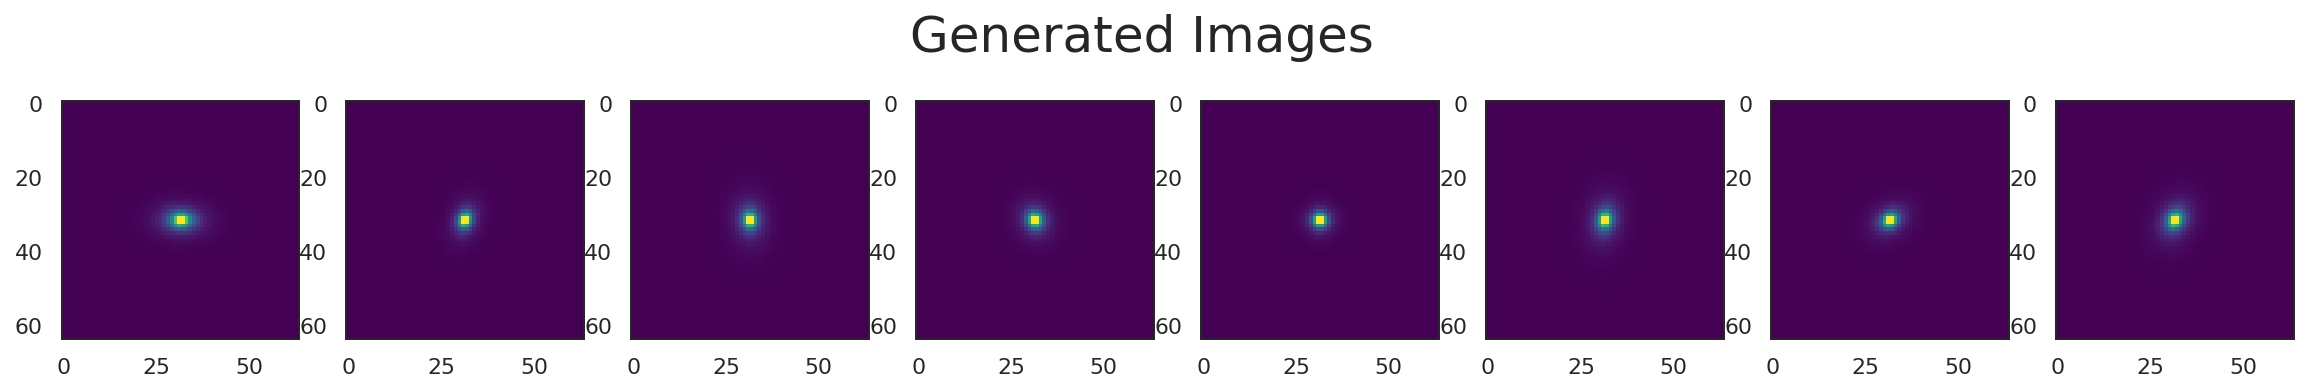

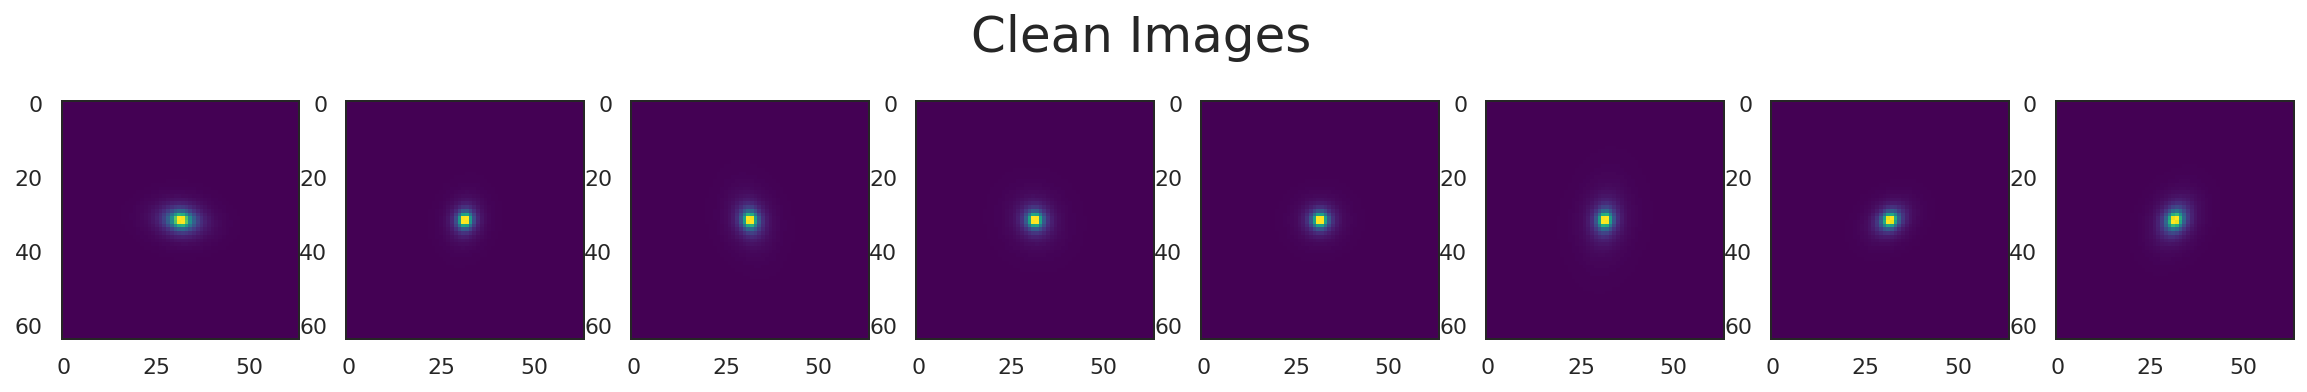

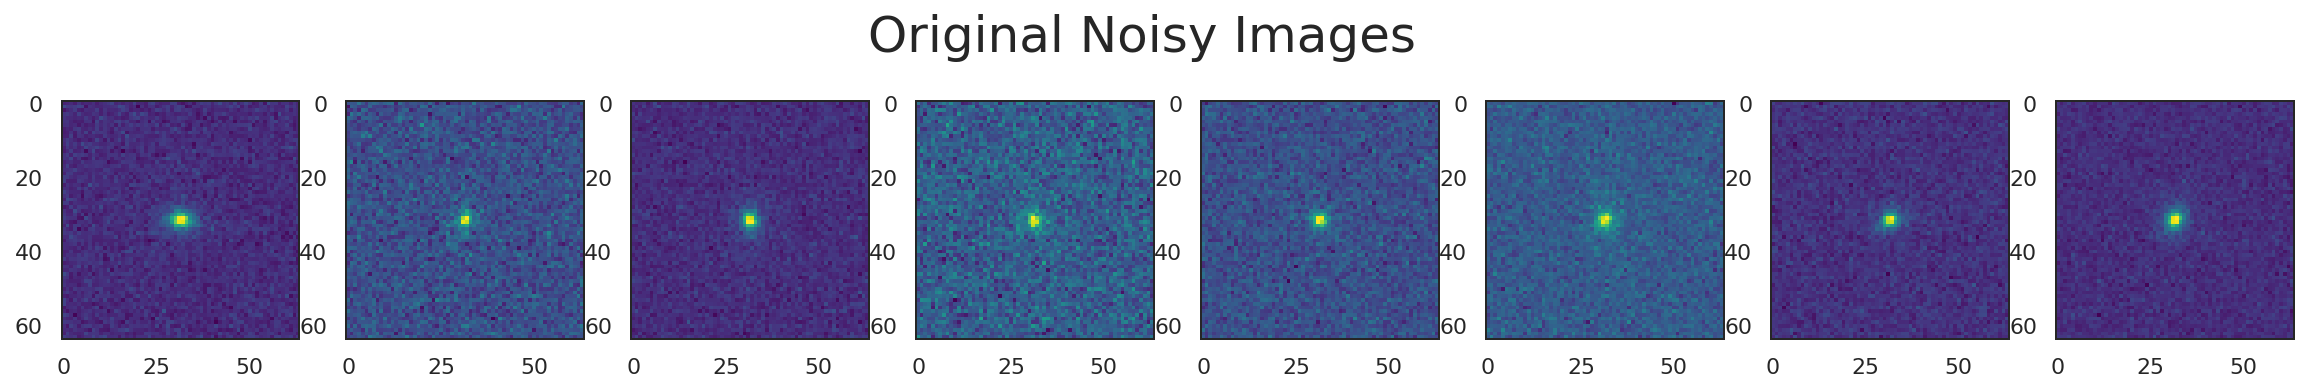

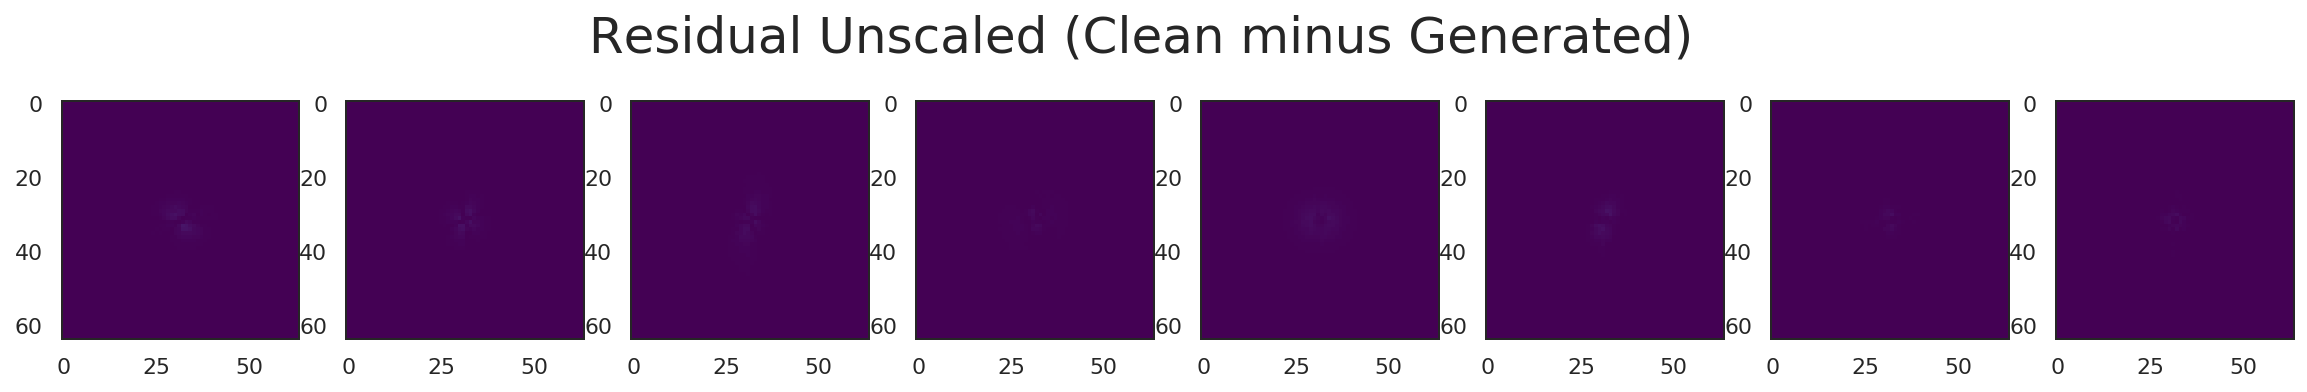

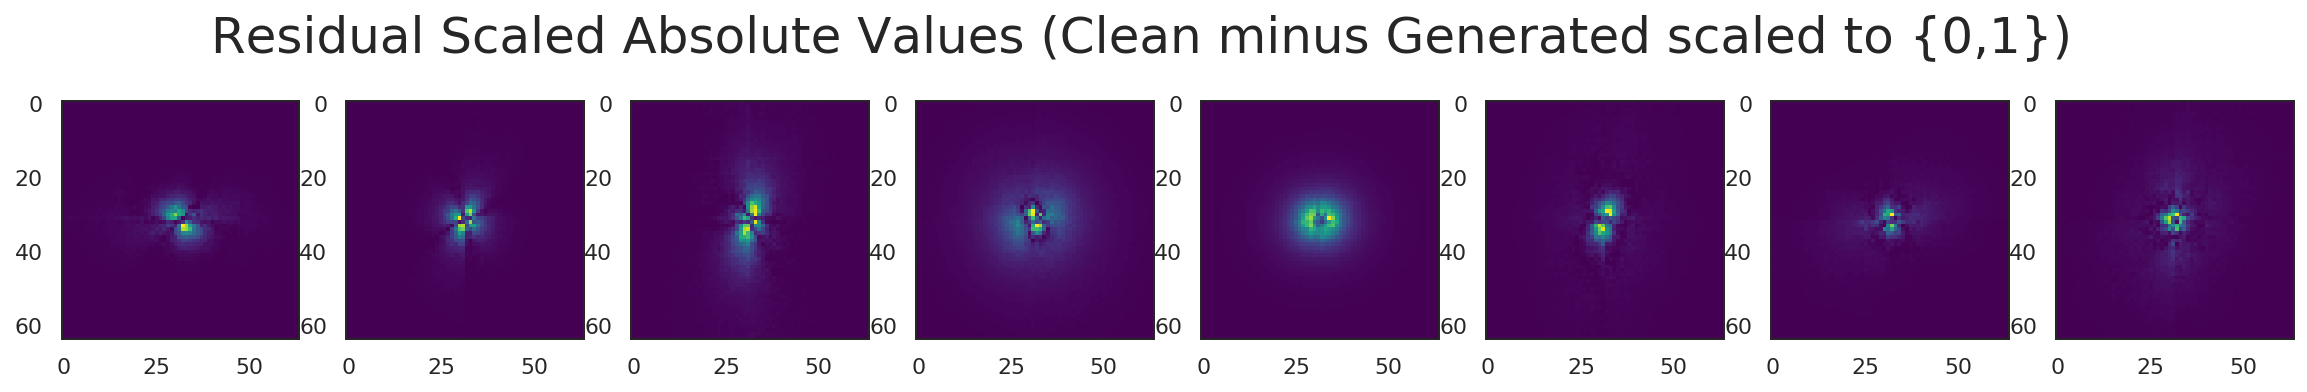

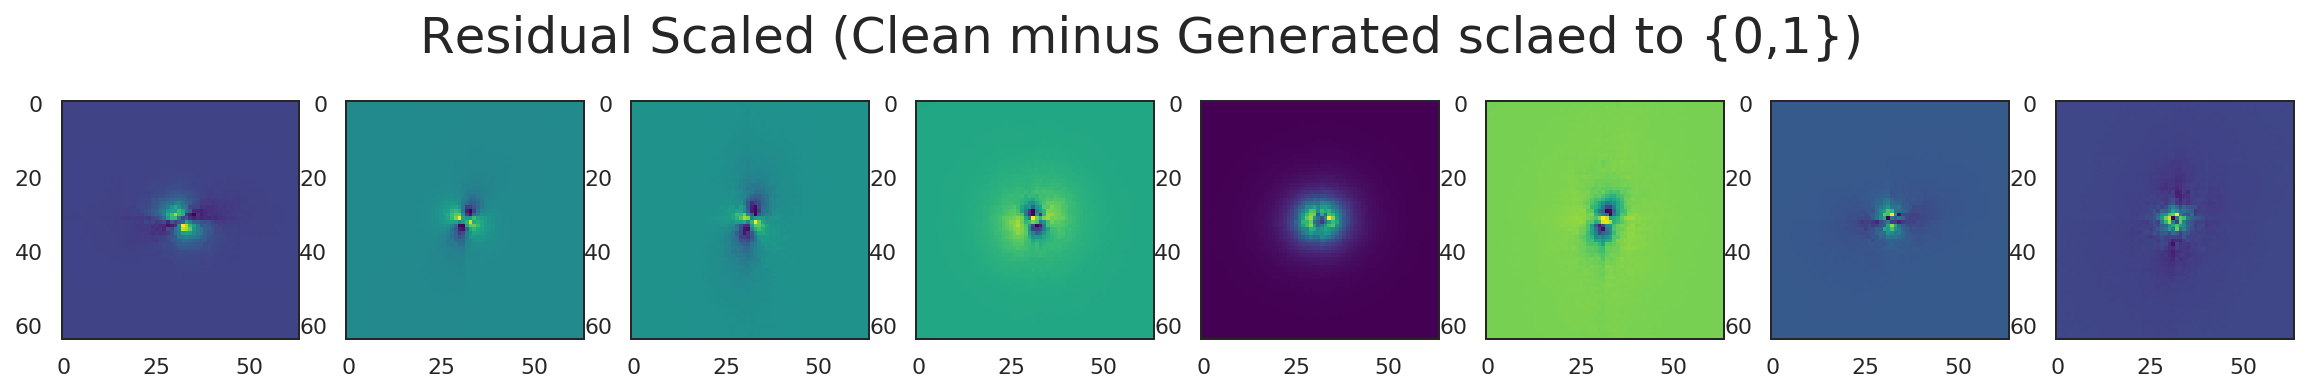

In [26]:
generate_images(CAE, val_ds_AE)

<div class='gc'> <b> Variance Analysis for Label </b> </div>

In [27]:
pred = variance_analysis(CAE, val_ds_AE, scaler1, label_val)

Bias         RMSE  Un-Explained Variance  \
Flux           1619.084229  6946.999512               0.020313   
Sersic Index      0.199250     0.857702               0.290166   
Sersic Radius    -0.001456     0.049980               0.126328   
g1               -0.002091     0.077765               0.077620   
g2                0.004234     0.080544               0.084316   

               Explained Variance  
Flux                     0.979687  
Sersic Index             0.709834  
Sersic Radius            0.873672  
g1                       0.922380  
g2                       0.915684

<div class='gc'> <b> Comparing True Labels with Predicted Labels </b> </div>

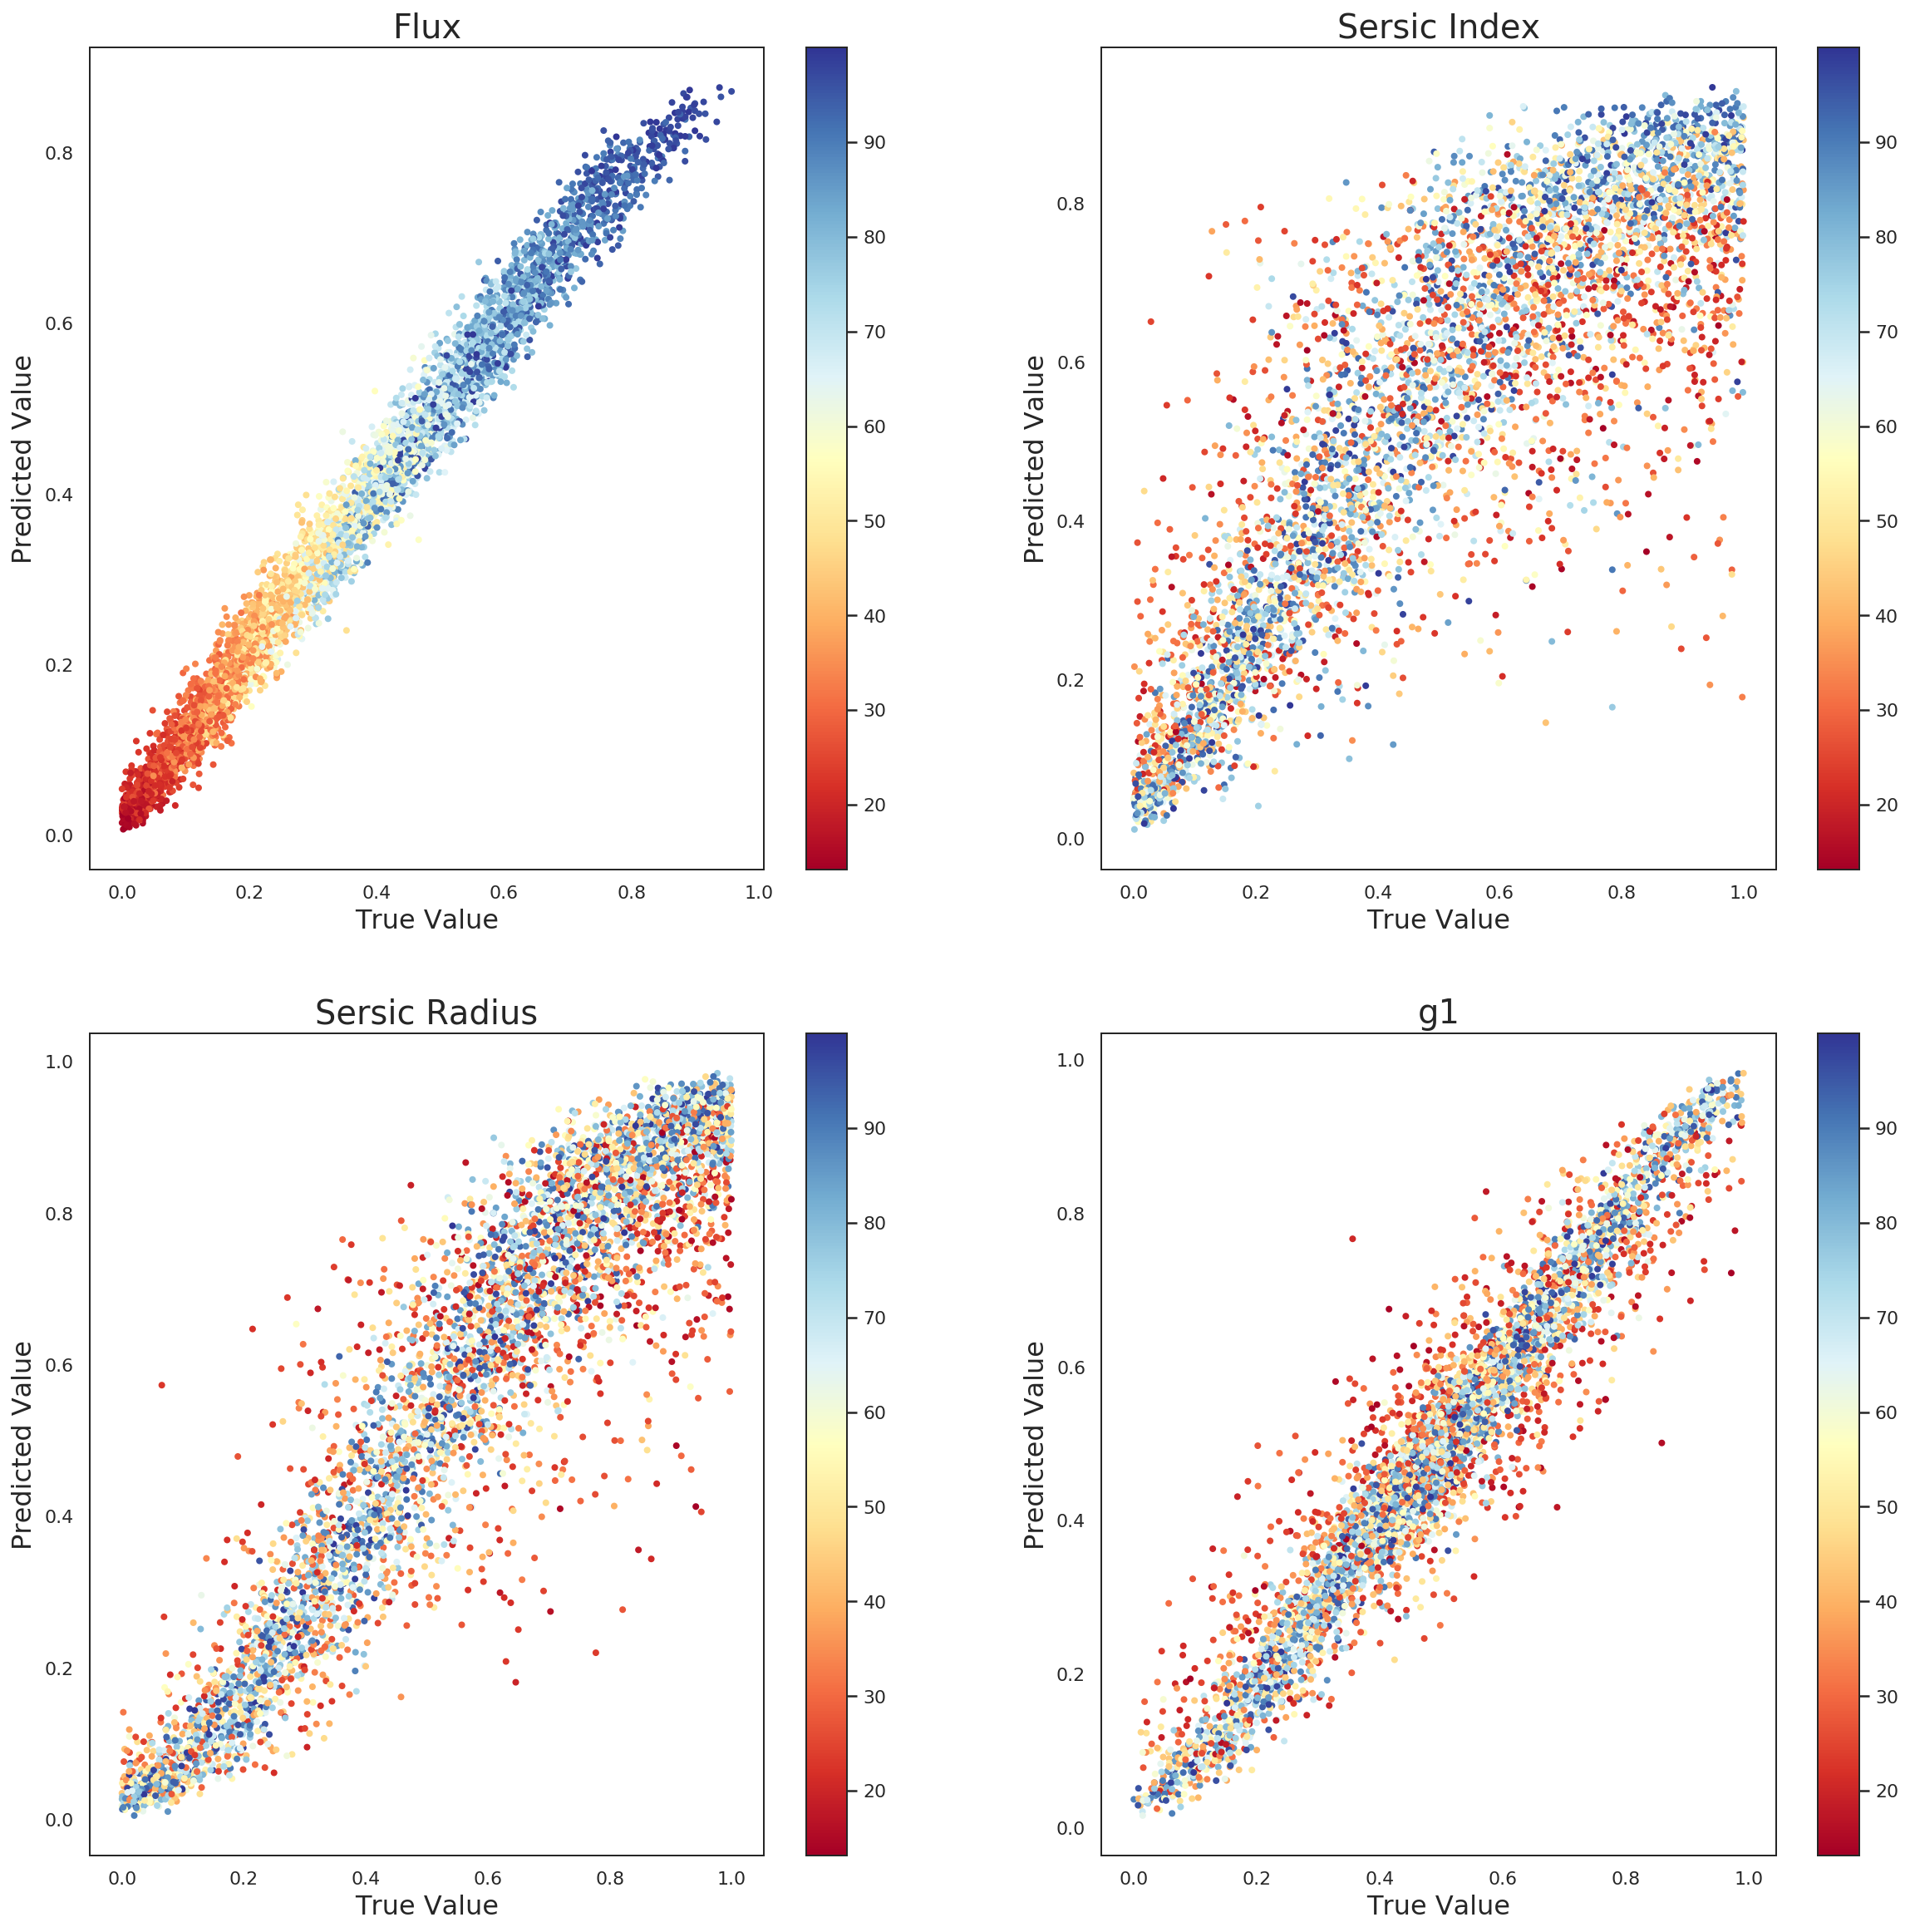

In [28]:
true_vs_pred(pred)

## <div class="theme"> End of Part 1 </div> 

## <div class="theme"> Part 2 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## GalSim Images with variable Sigma and fixed PSF

### <div class='exercise'> <b> Step 1: Load the Training and Validation dataset with variable noise and fixed PSF </b> </div>

In [29]:
# Read the data set
(image_train, image_val,
 image_nonoise_train,  image_nonoise_val,
 label_train,  label_val,
 psf_train, psf_val,
 snr_train, snr_val,
 sigma_train, sigma_val,
 psf_img_train, psf_img_val,
 stats_train, stats_val,
 mean_train, mean_val) = load_data(set=2)


Available variables:
    img
    img_nonoise
    label
    psf_r
    snr
    sigma
    train_test
    psf_image

Image Shape            = (200000, 64, 64)
No-noise Image Shape   = (200000, 64, 64)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)
Pixel Std-dev Shape    = (200000,)
Pixel Mean Shape       = (200000,)
PSF Image Shape        = (1, 64, 64)

Number of Training Points:    180000
Number of Validation Points:  20000



### <div class='exercise'> <b> Step 2: Normalize the Labels, Sigma, PSF, Stats & Noiseless Images </b> </div>

<div class='gc'> <b> Normalize Labels, PSF, Sigma, Stats </b> </div>

In [30]:
# Normalize the label, etc.
label_train,  label_val, scaler2 = norm_label(label_train, label_val)

<div class='gc'> <b> Normalize the Images </b> </div>

In [31]:
# Normalize the Images
image_nonoise_train, image_nonoise_val = norm_image(image_nonoise_train, image_nonoise_val)

### <div class='exercise'> <b> Step 3: Create Data Pipeline </b> </div>

<div class='gc'> <b> Function to Load Data and Divide data into Training and Validation Set </b> </div>

In [32]:
# Create Tensorflow Dataset
training, validation = create_dataset(set=2)

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [33]:
# Data pipeline for Conditional Auto-encoder
tr_ds_AE = training.map(
    pipeline_noisy_image_to_clean_image).shuffle(shuffle).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_AE = validation.map(
    pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### <div class='exercise'> <b> Step 4: Train Conditional Auto-encoder </b> </div>

In [34]:
train_CAE(CAE, set=2)

704/704 [==============================] - 143s 203ms/step - loss: 2.8451 - Decoder_loss: 0.0195 - Cond_Encoder_loss: 0.5651
Training Loss:   [2.845063018527898, 0.019507745, 0.565111]
79/79 [==============================] - 16s 202ms/step - loss: 2.8567 - Decoder_loss: 0.0196 - Cond_Encoder_loss: 0.5674
Validation Loss: [2.856732178337966, 0.019566603, 0.56743324]


### <div class='exercise'> <b> Step 5: Performance Analysis </b> </div>

<div class='gc'> <b> Generating reconstructed images for visual inspection </b> </div>

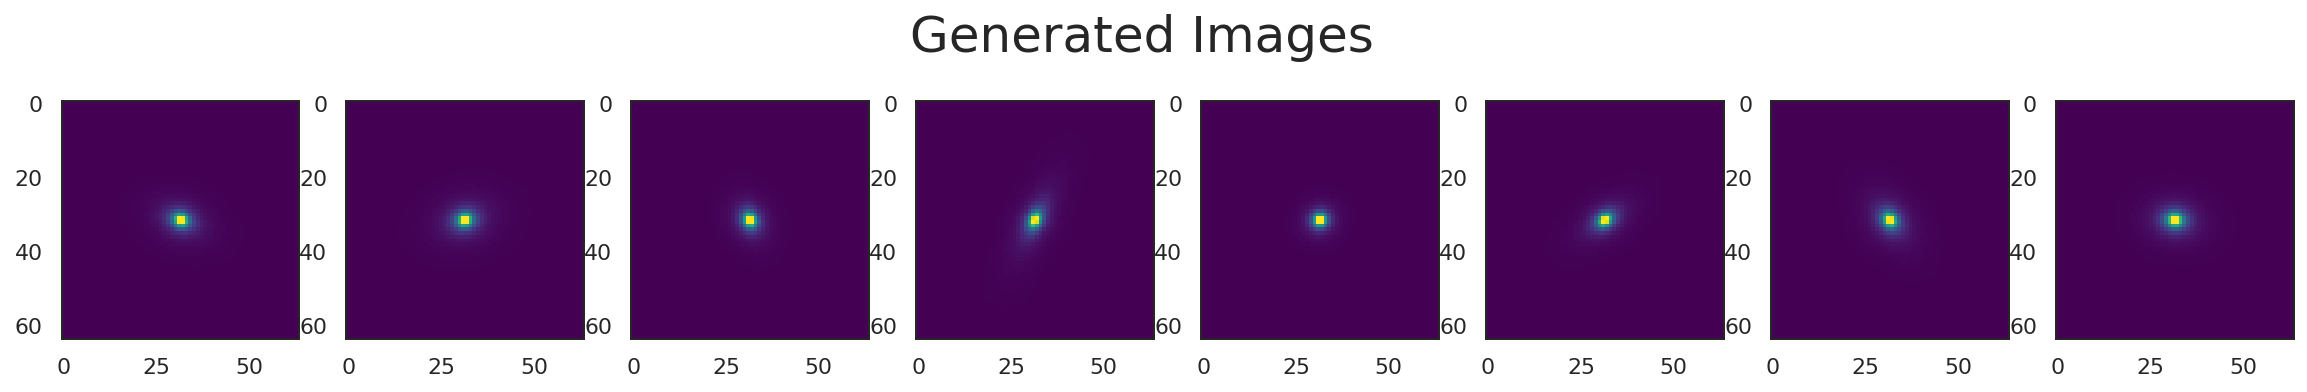

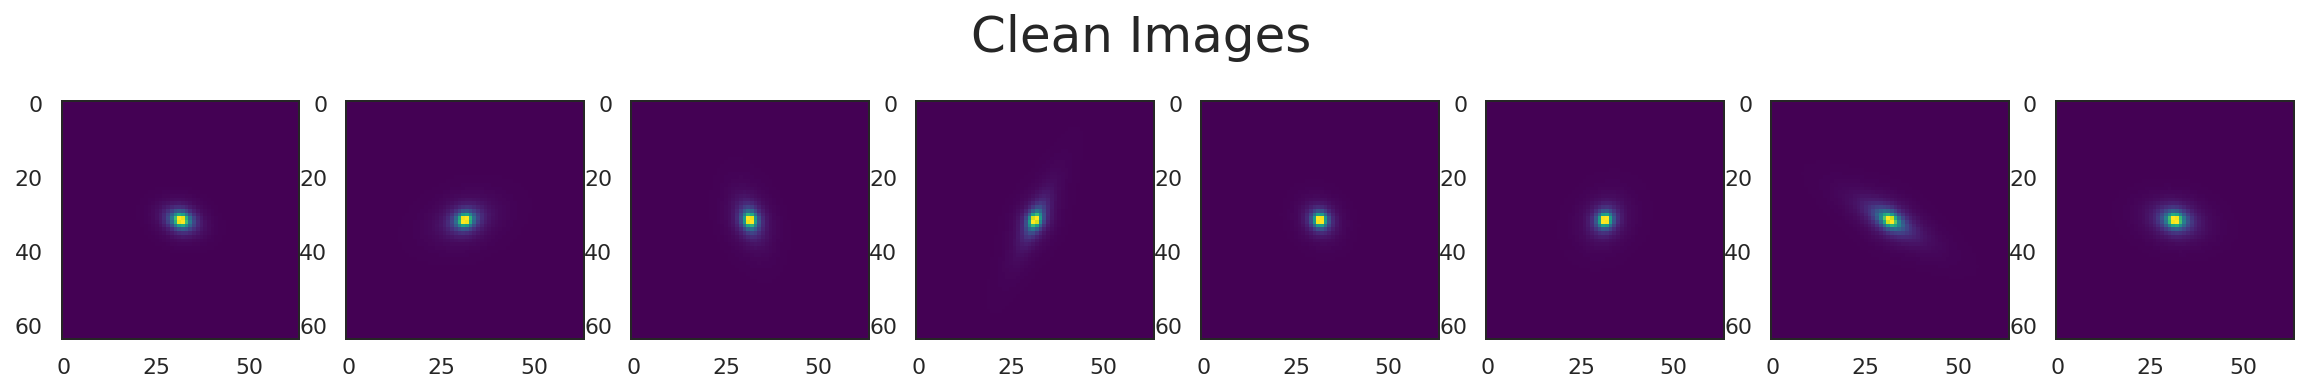

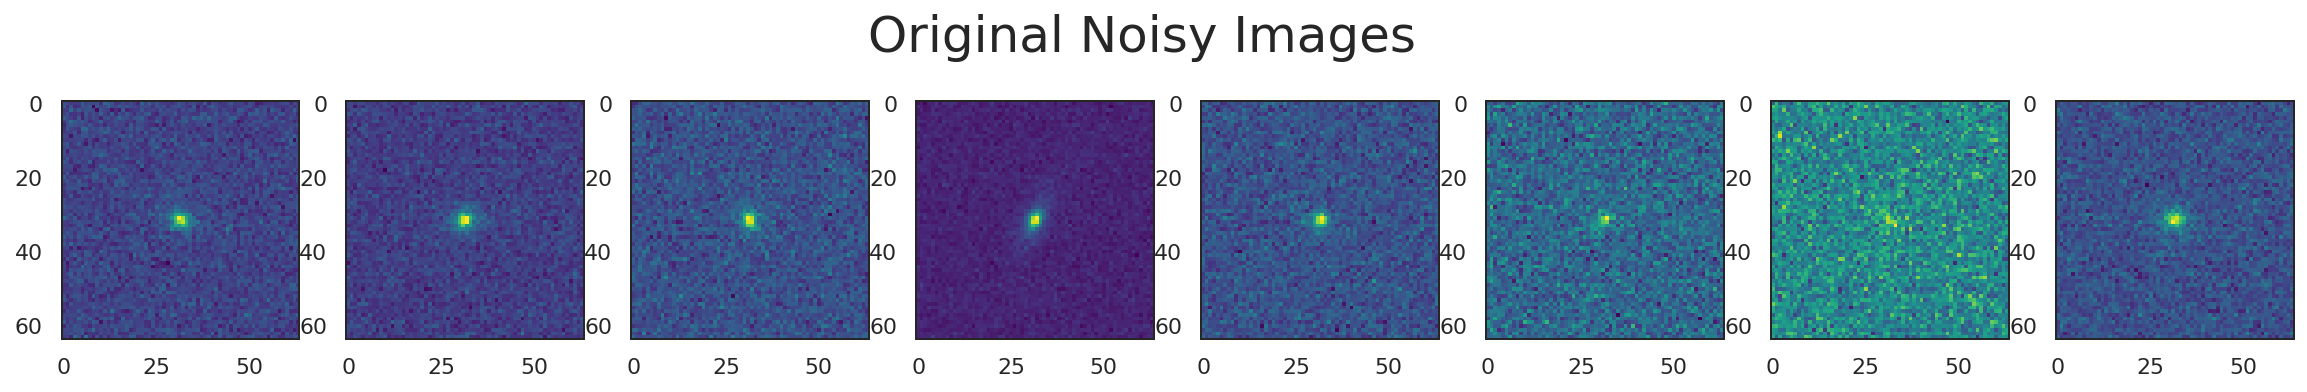

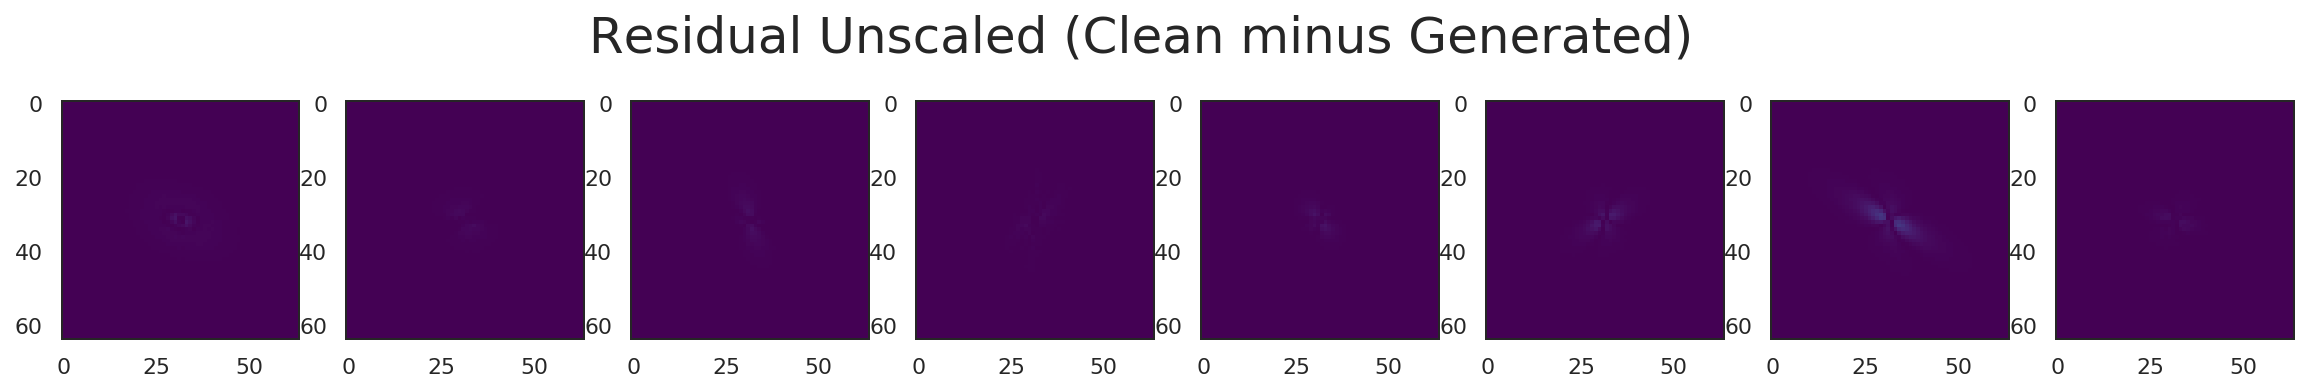

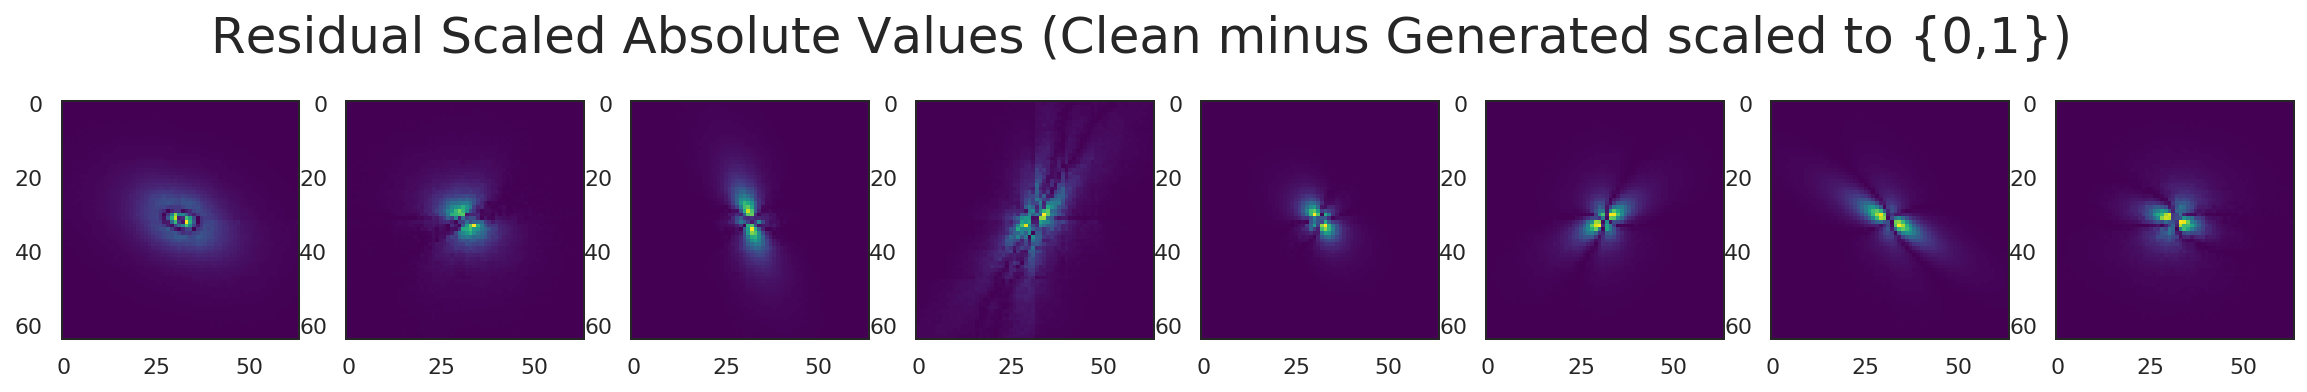

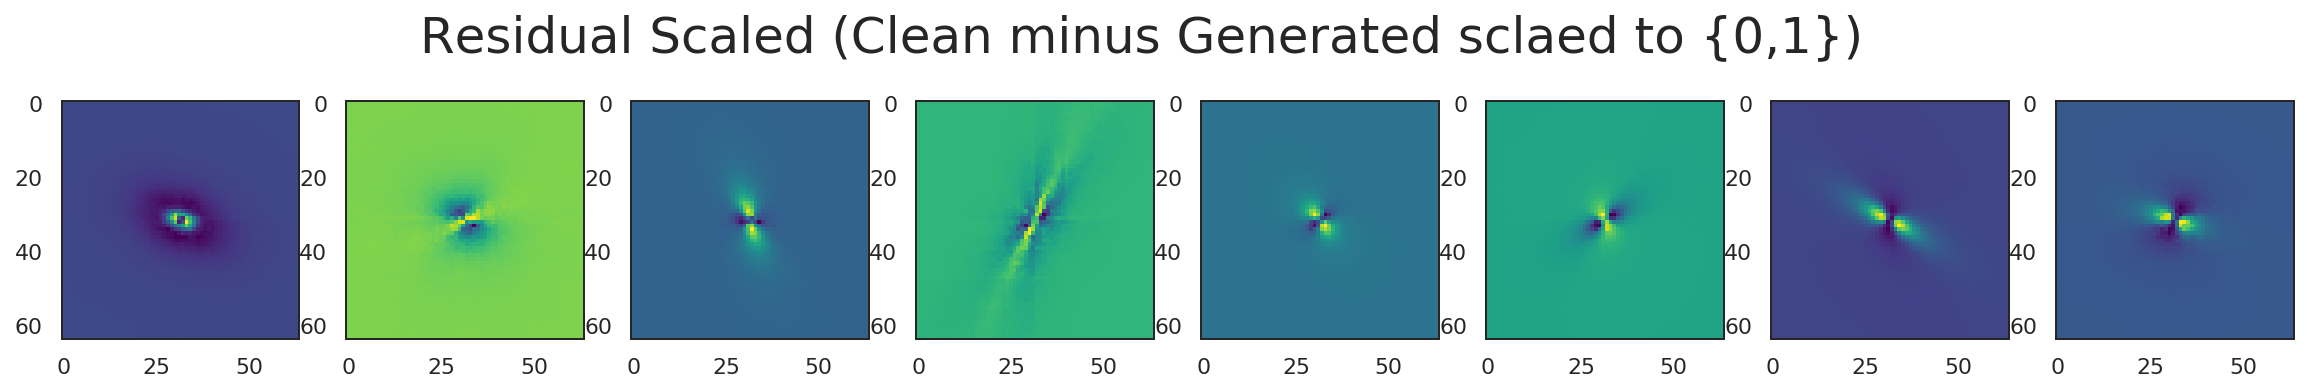

In [35]:
generate_images(CAE, val_ds_AE)

<div class='gc'> <b> Variance Analysis for Label </b> </div>

In [36]:
pred = variance_analysis(CAE, val_ds_AE, scaler2, label_val)

Bias          RMSE  Un-Explained Variance  \
Flux           1127.087036  11616.478516               0.020383   
Sersic Index      0.018756      0.870229               0.298704   
Sersic Radius     0.005584      0.052814               0.140574   
g1               -0.005338      0.090293               0.106539   
g2               -0.008984      0.085966               0.094912   

               Explained Variance  
Flux                     0.979617  
Sersic Index             0.701296  
Sersic Radius            0.859426  
g1                       0.893461  
g2                       0.905088

<div class='gc'> <b> Comparing True Labels with Predicted Labels </b> </div>

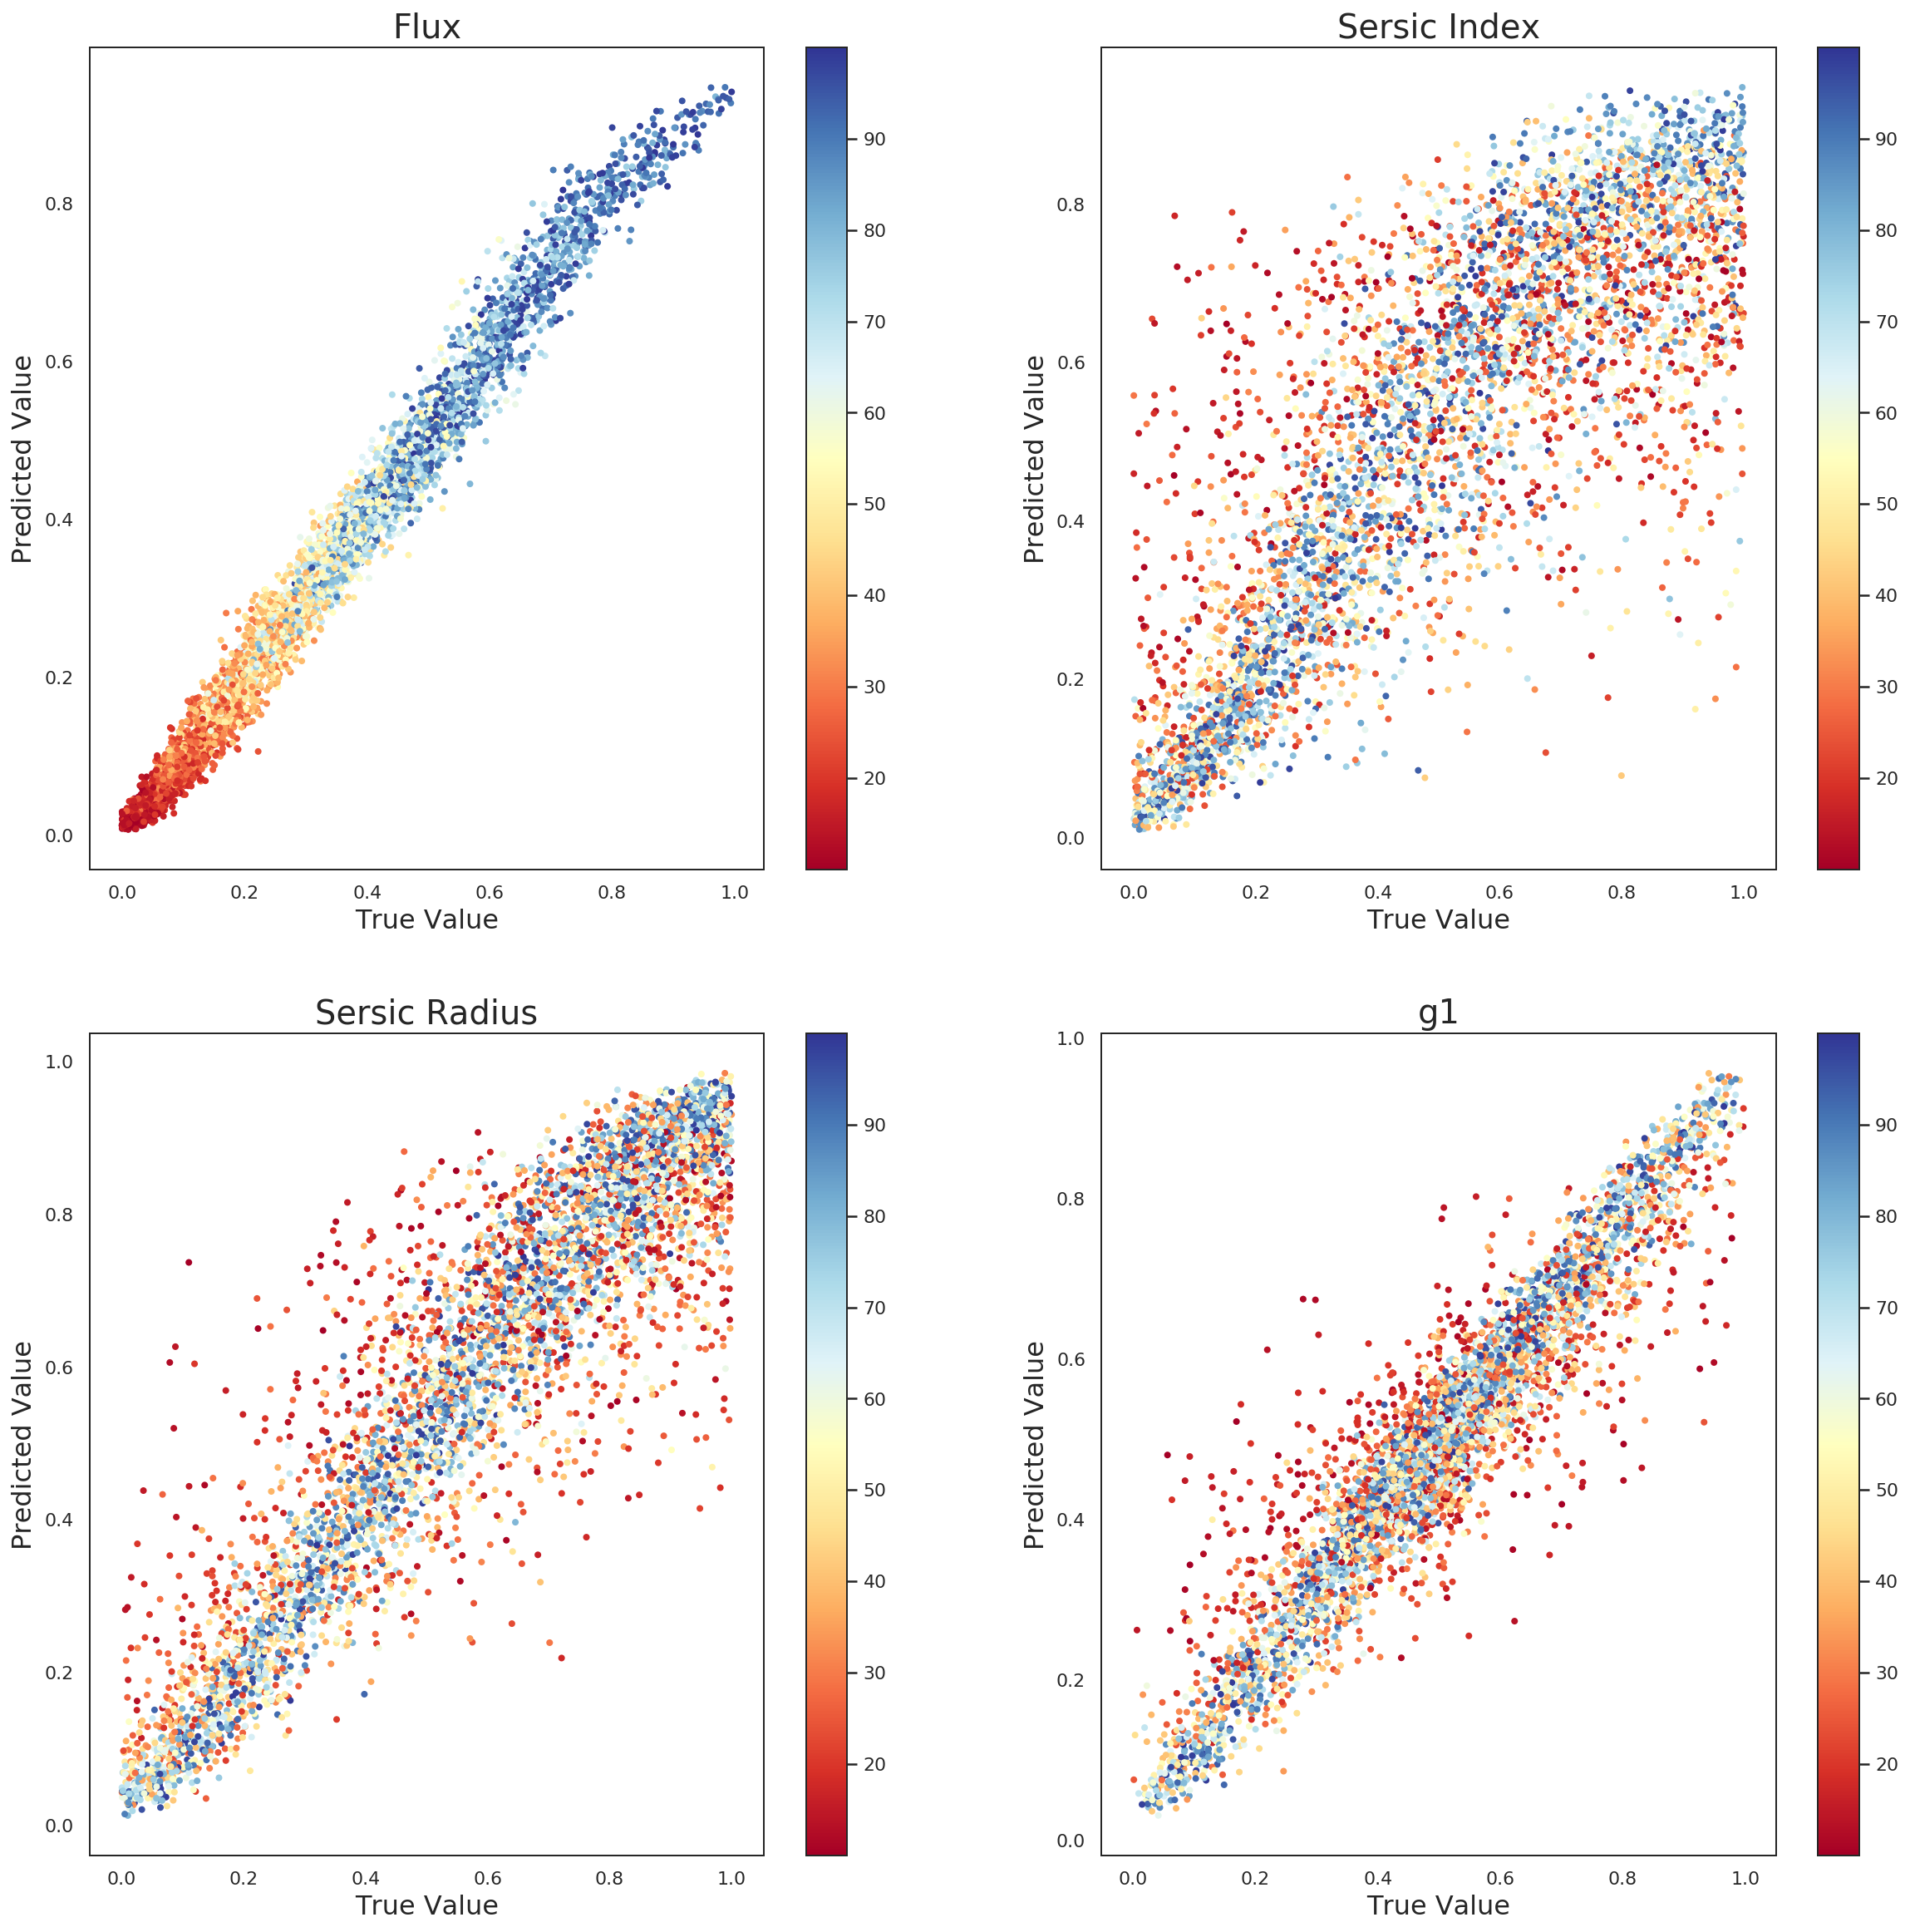

In [37]:
true_vs_pred(pred)

## <div class="theme"> End of Part 2 </div> 

## <div class="theme"> Part 3 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## GalSim Images with variable Sigma and variable PSF

### <div class='exercise'> <b> Step 1: Load the Training and Validation dataset with variable noise and variable PSF </b> </div>

In [38]:
# Read the data set
(image_train, image_val,
 image_nonoise_train,  image_nonoise_val,
 label_train,  label_val,
 psf_train, psf_val,
 snr_train, snr_val,
 sigma_train, sigma_val,
 psf_img_train, psf_img_val,
 stats_train, stats_val,
 mean_train, mean_val) = load_data(set=3)


Available variables:
    img
    img_nonoise
    label
    psf_r
    snr
    sigma
    psf_image

Image Shape            = (200000, 64, 64)
No-noise Image Shape   = (200000, 64, 64)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)
Pixel Std-dev Shape    = (200000,)
Pixel Mean Shape       = (200000,)
PSF Image Shape        = (200000, 64, 64)

Number of Training Points:    180000
Number of Validation Points:  20000



### <div class='exercise'> <b> Step 2: Normalize the Labels, Sigma, PSF, Stats & Noiseless Images </b> </div>

<div class='gc'> <b> Normalize Labels, PSF, Sigma, Stats </b> </div>

In [39]:
# Normalize the label, etc.
label_train,  label_val, scaler3 = norm_label(label_train, label_val)

<div class='gc'> <b> Normalize the Images </b> </div>

In [40]:
# Normalize the Images
image_nonoise_train, image_nonoise_val = norm_image(image_nonoise_train, image_nonoise_val)

### <div class='exercise'> <b> Step 3: Create Data Pipeline </b> </div>

<div class='gc'> <b> Function to Load Data and Divide data into Training and Validation Set </b> </div>

In [41]:
# Create Tensorflow Dataset
training, validation = create_dataset(set=3)

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [42]:
# Data pipeline for Conditional Auto-encoder
tr_ds_AE = training.map(
    pipeline_noisy_image_to_clean_image).shuffle(shuffle).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_AE = validation.map(
    pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### <div class='exercise'> <b> Step 4: Train Conditional Auto-encoder </b> </div>

In [43]:
train_CAE(CAE, set=3)

704/704 [==============================] - 143s 203ms/step - loss: 2.9063 - Decoder_loss: 0.0306 - Cond_Encoder_loss: 0.5751
Training Loss:   [2.9063241414048453, 0.030645847, 0.57513547]
79/79 [==============================] - 16s 201ms/step - loss: 2.9291 - Decoder_loss: 0.0306 - Cond_Encoder_loss: 0.5797
Validation Loss: [2.929148360143734, 0.030591482, 0.57971126]


### <div class='exercise'> <b> Step 5: Performance Analysis </b> </div>

<div class='gc'> <b> Generating reconstructed images for visual inspection </b> </div>

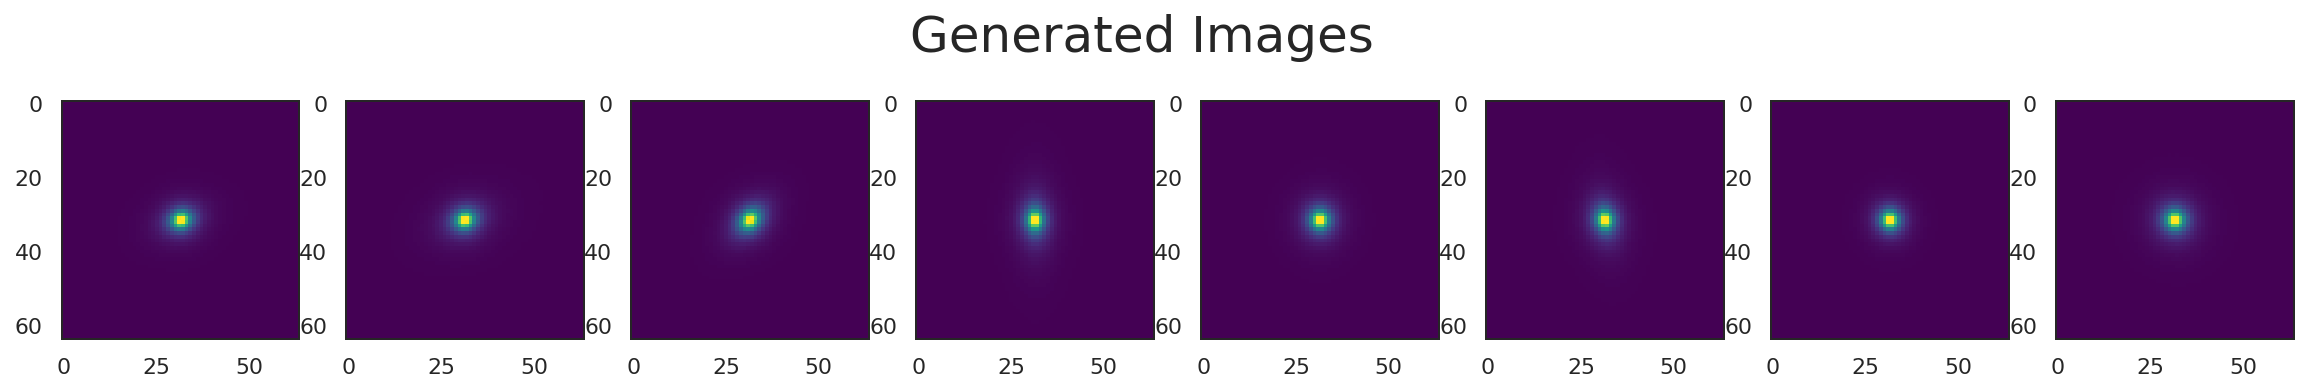

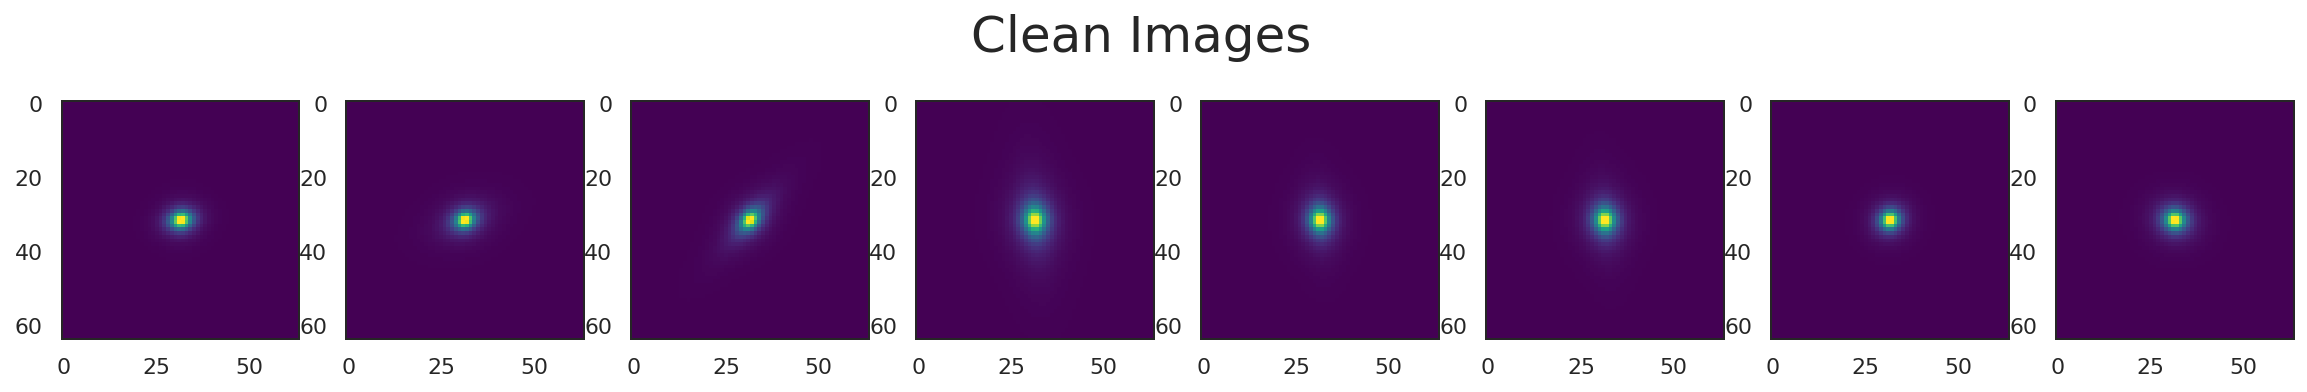

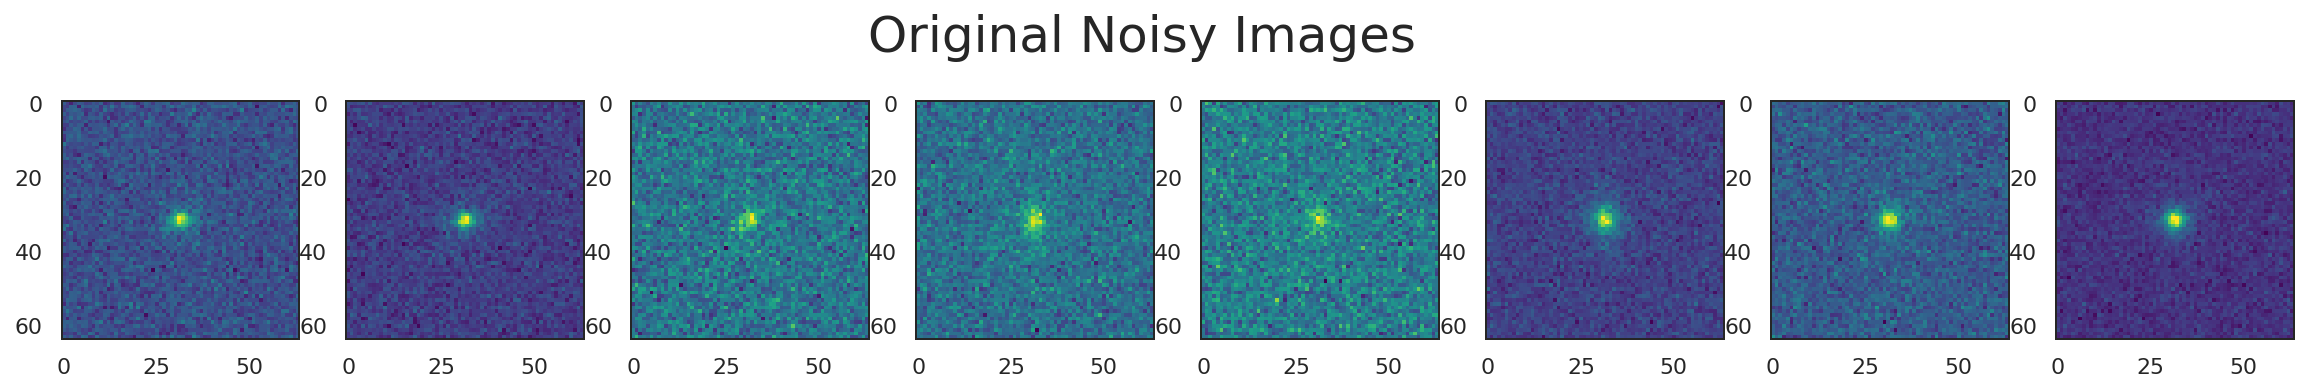

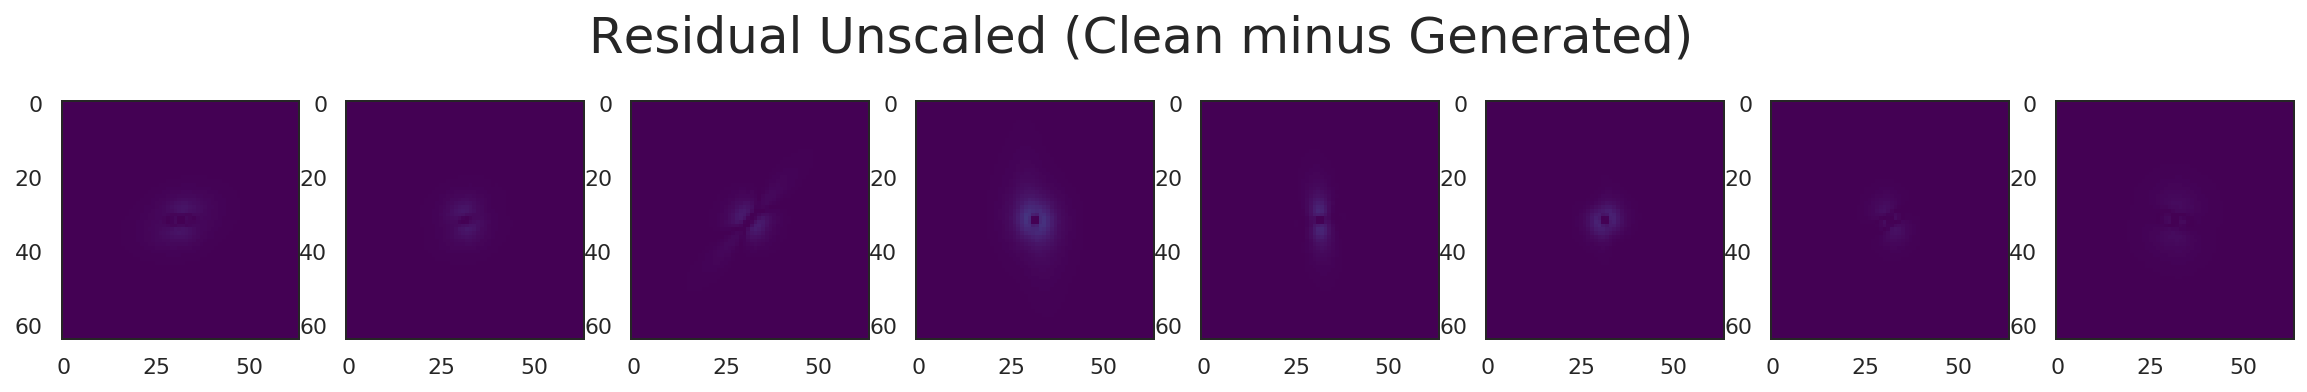

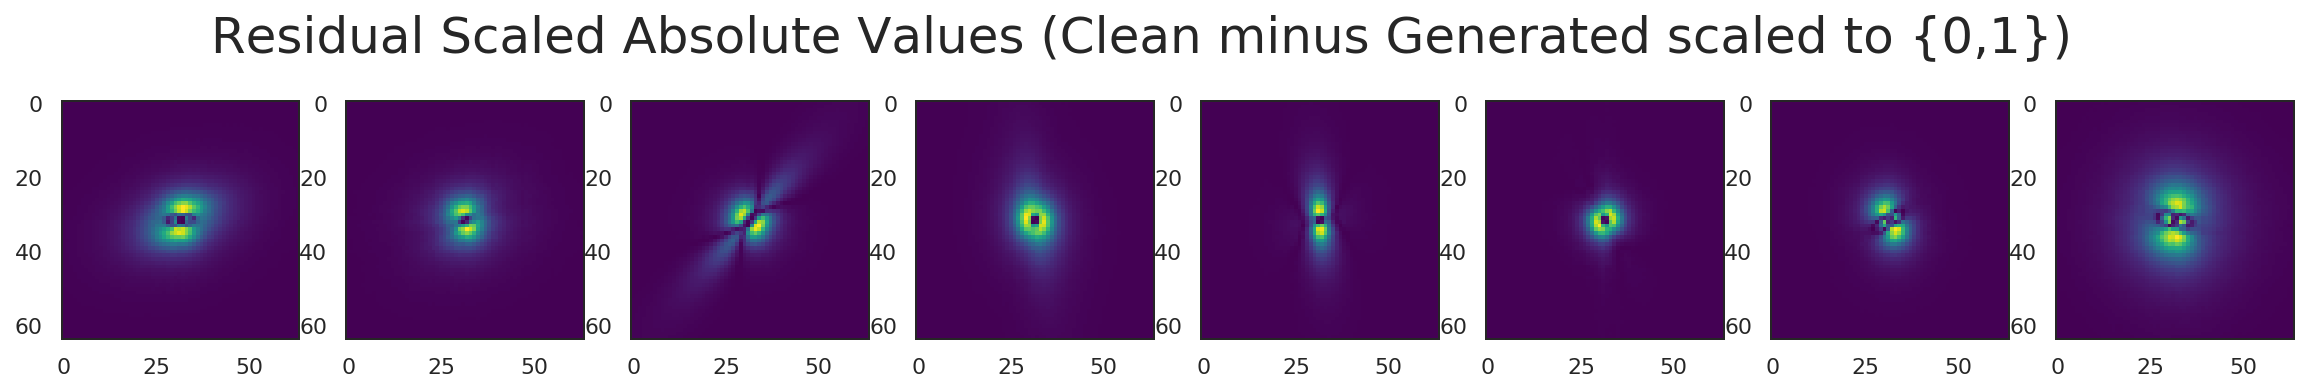

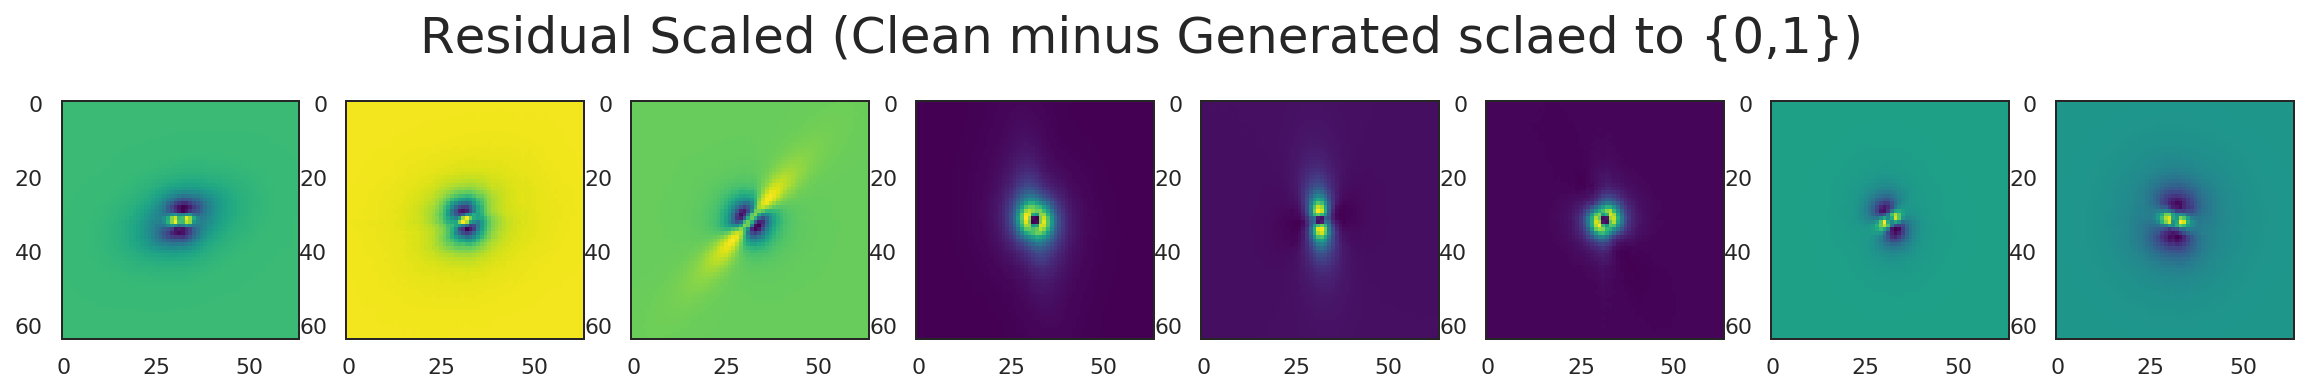

In [44]:
generate_images(CAE, val_ds_AE)

<div class='gc'> <b> Variance Analysis for Label </b> </div>

In [45]:
pred = variance_analysis(CAE, val_ds_AE, scaler3, label_val)

Bias          RMSE  Un-Explained Variance  \
Flux           5778.723633  12969.458008               0.019043   
Sersic Index     -0.079929      1.061235               0.444219   
Sersic Radius     0.010018      0.058071               0.167296   
g1               -0.005838      0.112844               0.168842   
g2                0.004779      0.109117               0.157293   

               Explained Variance  
Flux                     0.980957  
Sersic Index             0.555781  
Sersic Radius            0.832704  
g1                       0.831158  
g2                       0.842707

<div class='gc'> <b> Comparing True Labels with Predicted Labels </b> </div>

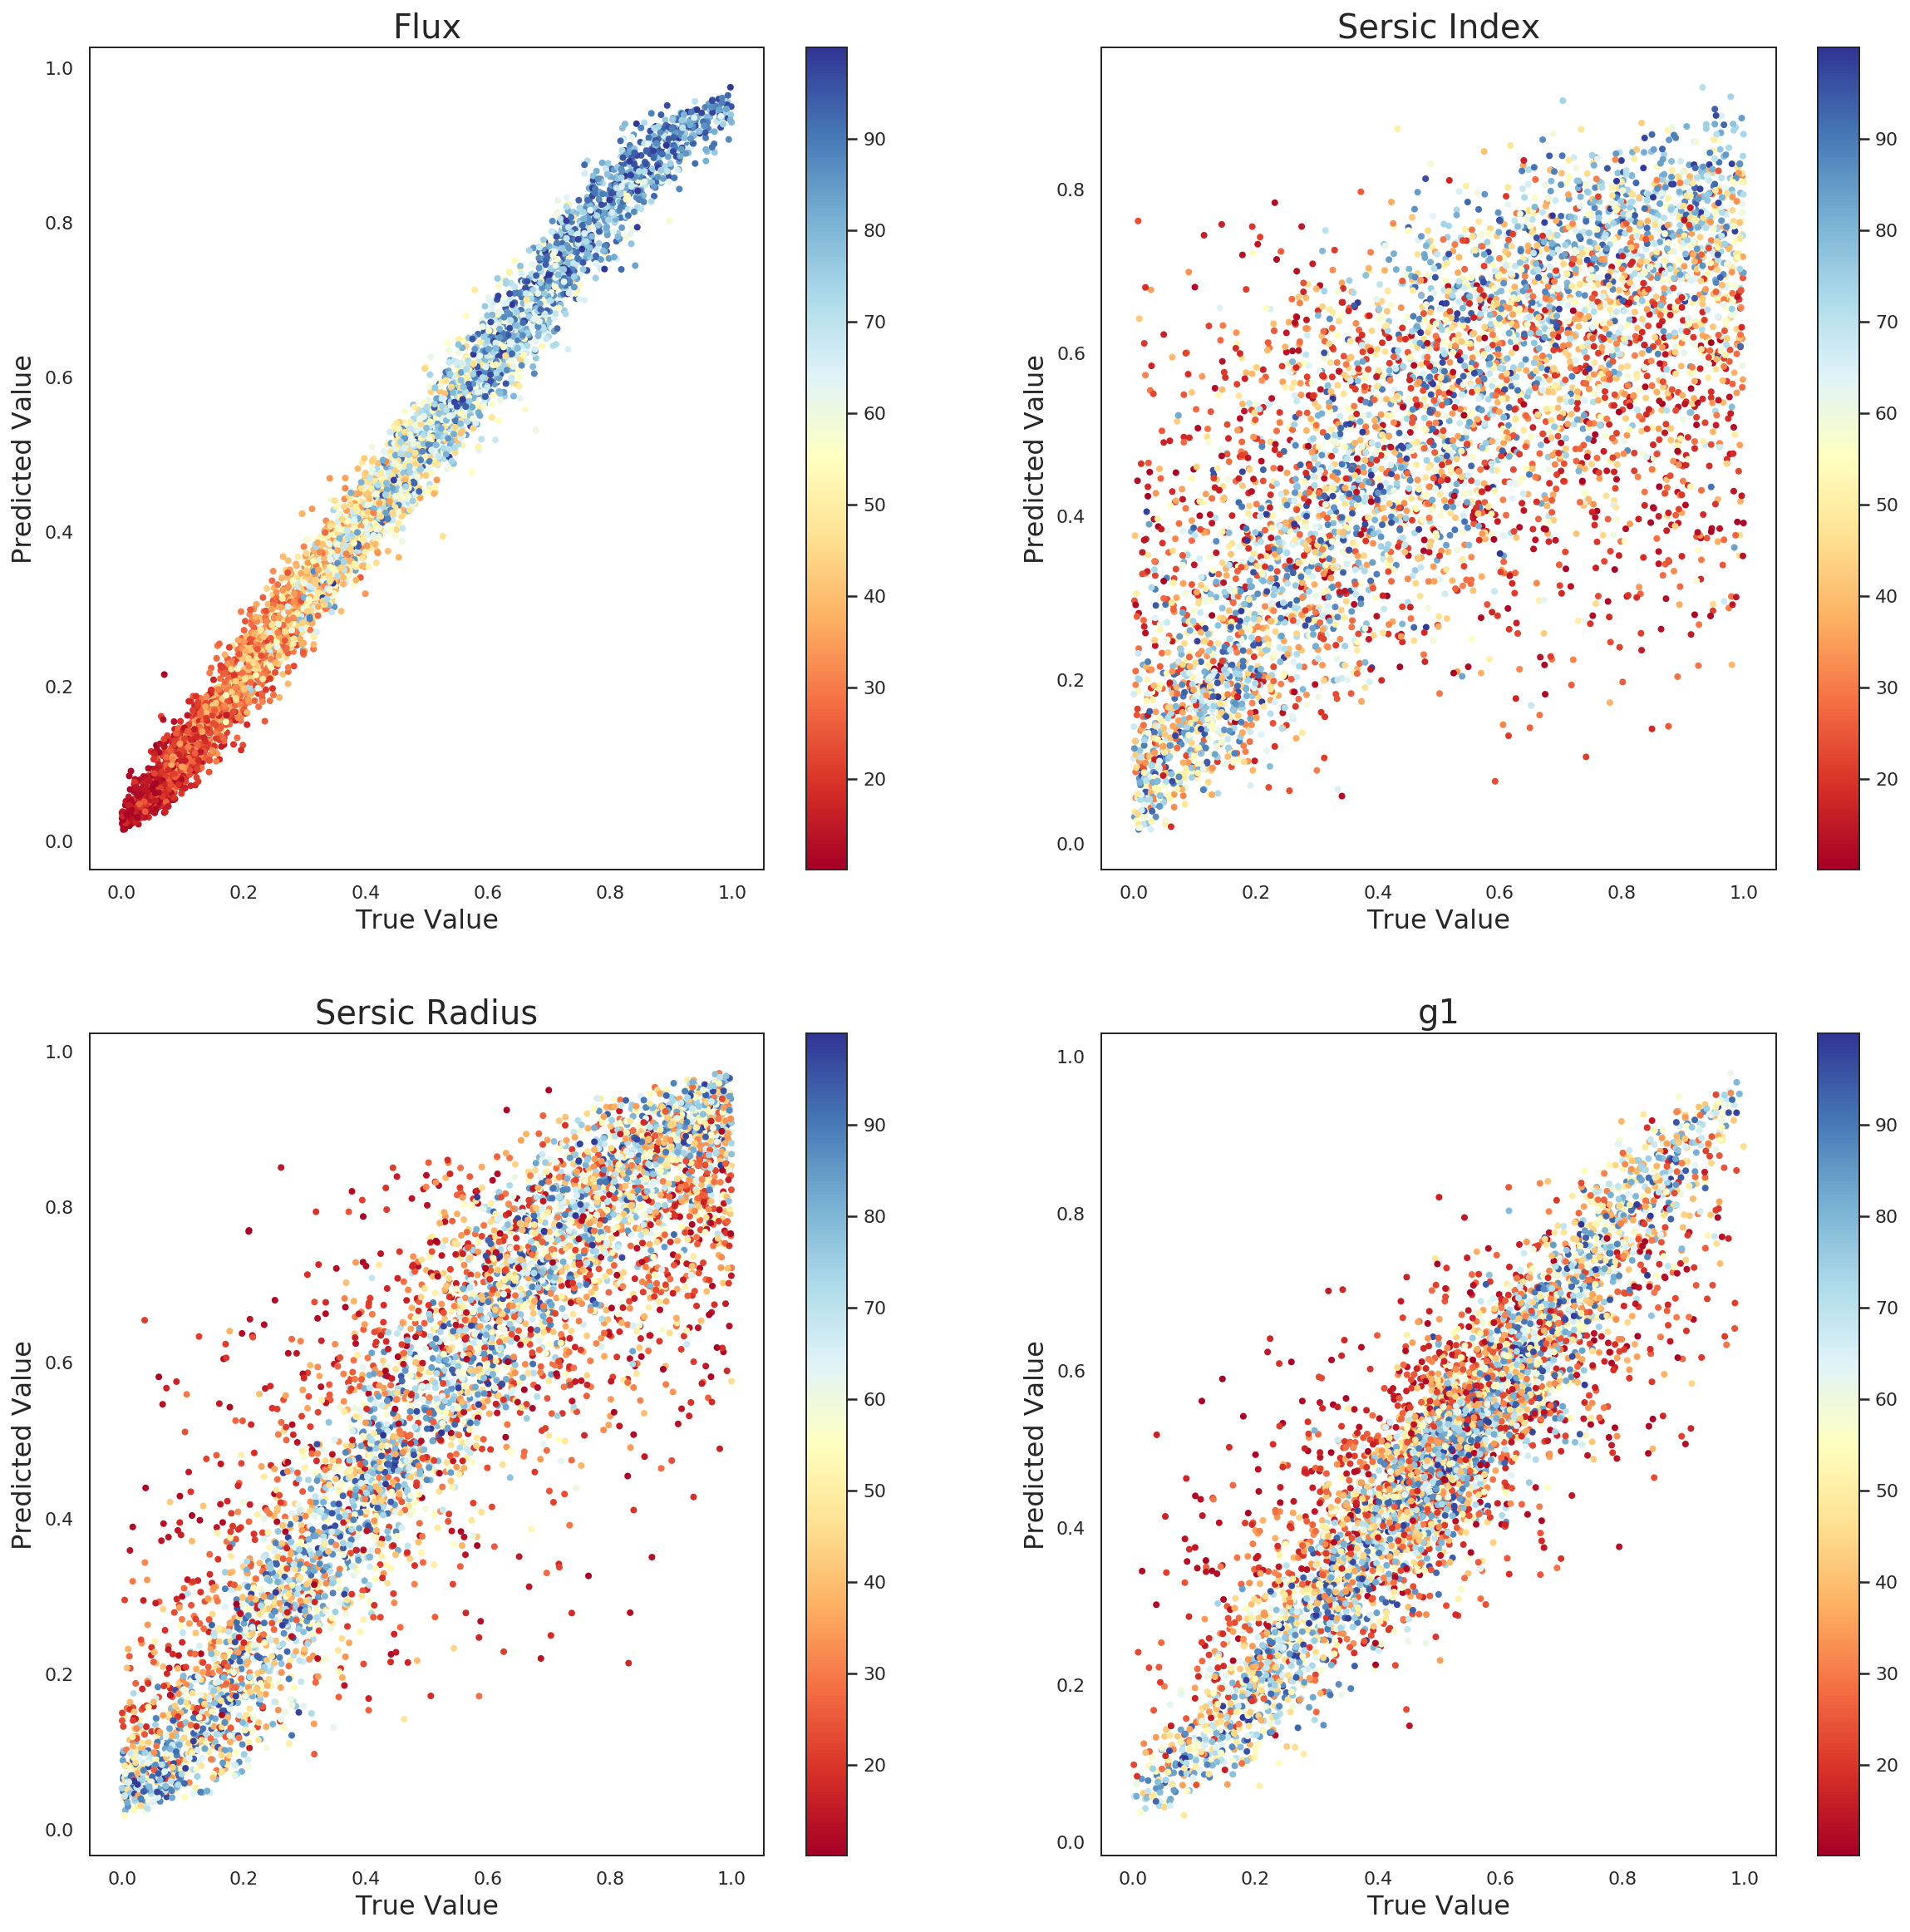

In [46]:
true_vs_pred(pred)

## <div class="theme"> End of Part 3 </div> 

## <div class="theme"> Part 4 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Test Dataset:  SNR = 30


| \# Samples | Avg. SNR | Flux [$10^5$] | Sersic index | Sersic radius | g1     | g2   | PSF  | Noise | Link                                                |
| ---------- | -------- | ------------- | ------------ | ------------- | ------ | ---- | ---- | ----- | --------------------------------------------------- |
| 10,000     | 29.95    | 1.0           | 3.0          | 0.3           | -0.069 | 0.15 | 0.5  | 400   | https://s3.amazonaws.com/measure.galaxies/snr30.npz |

### <div class='exercise'> <b> Step 1: Load the Testing dataset with average SNR of 30 </b> </div>

In [47]:
# Read the data set
(image_test,
 image_nonoise_test,
 label_test,
 psf_test,
 snr_test,
 sigma_test,
 psf_img_test,
 stats_test,
 mean_test) = load_data(set=4, test=True)


Available variables:
    img
    img_nonoise
    label
    psf_r
    psf_img
    snr
    sigma
    psf_image

Image Shape            = (10000, 64, 64)
No-noise Image Shape   = (10000, 64, 64)
Label Shape            = (10000, 5)
SNR Shape              = (10000,)
Sigma Shape            = (10000,)
PSF-R Shape            = (10000,)
Pixel Std-dev Shape    = (10000,)
Pixel Mean Shape       = (10000,)
PSF Image Shape        = (1, 64, 64)


### <div class='exercise'> <b> Step 2: Normalize the data </b> </div>

In [48]:
# Normalize the labels
label_test = norm_label(label_test, scaler=scaler2)

# Normalize the Images
image_nonoise_test = norm_image(image_nonoise_test, test=True)

### <div class='exercise'> <b> Step 3: Create Data Pipeline </b> </div>

<div class='gc'> <b> Create Dataset </b> </div>

In [49]:
# Create Tensorflow Dataset
testing = create_dataset(test=True)

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [50]:
test_ds = testing.map(
    pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### <div class='exercise'> <b> Step 4: Load Conditional Auto-encoder trained with variable Noise and fixed PSF </b> </div>

In [51]:
CAE.load_weights(paths[1])

### <div class='exercise'> <b> Step 5: Performance Analysis </b> </div>

<div class='gc'> <b> Generating reconstructed images for visual inspection </b> </div>

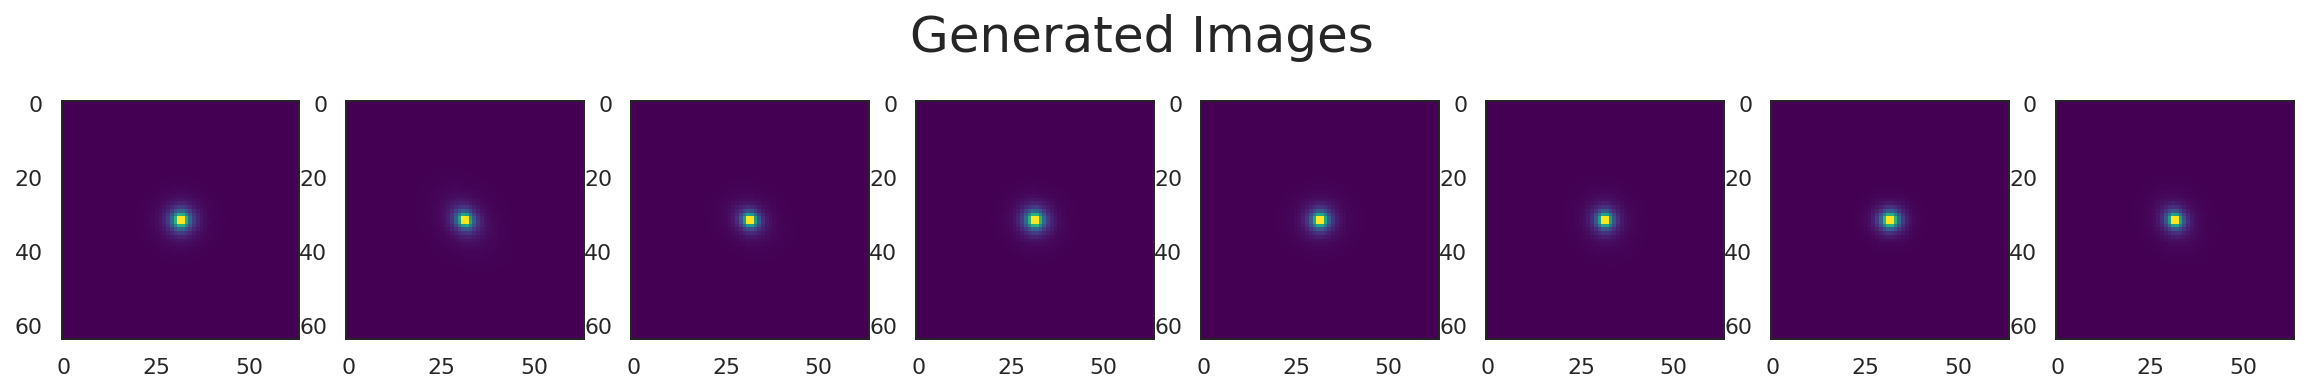

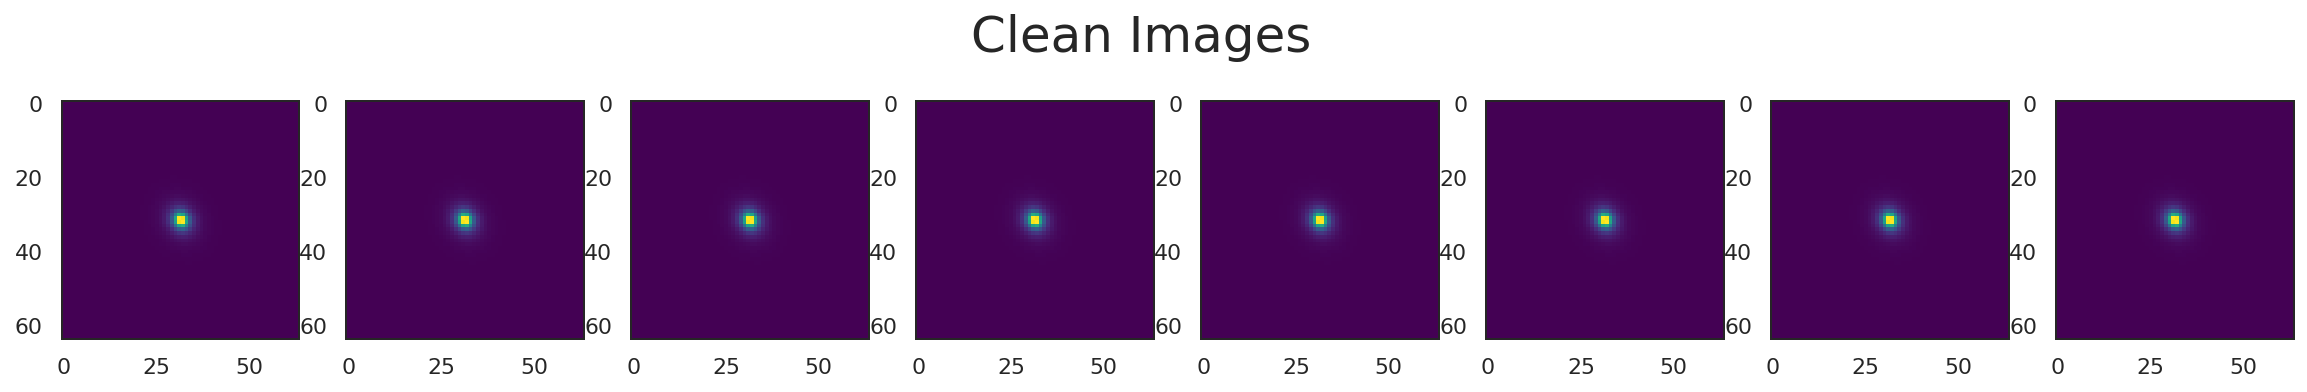

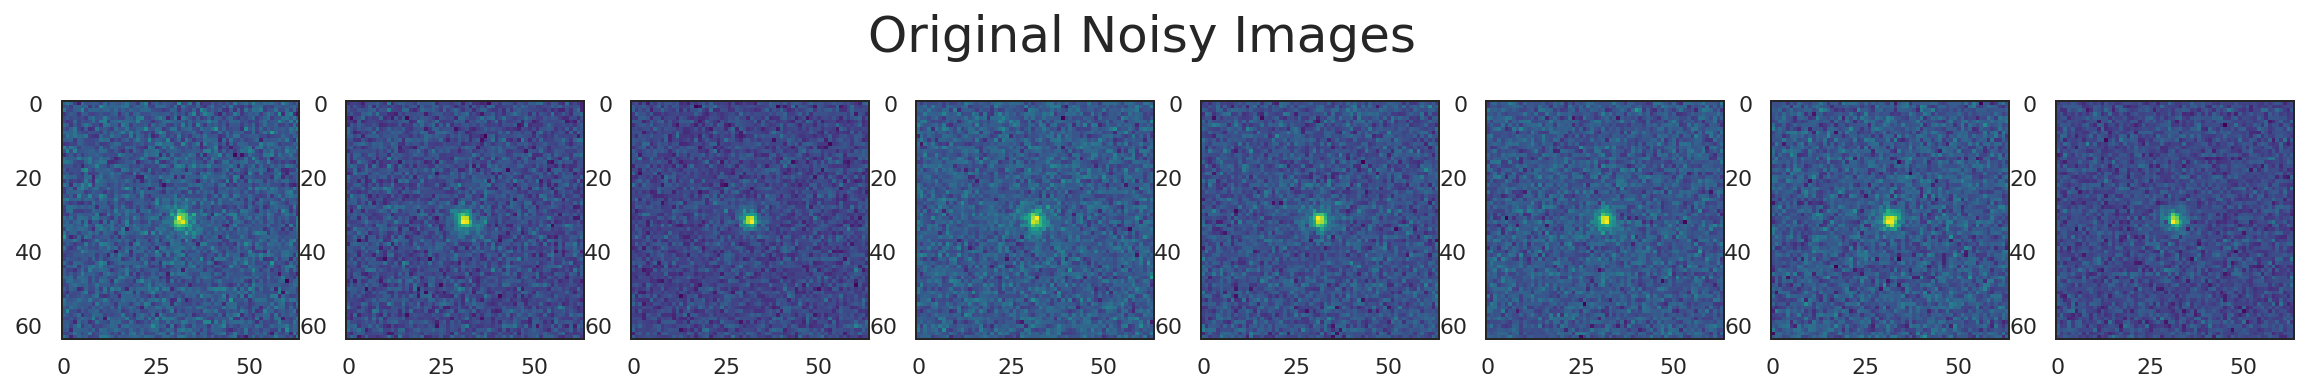

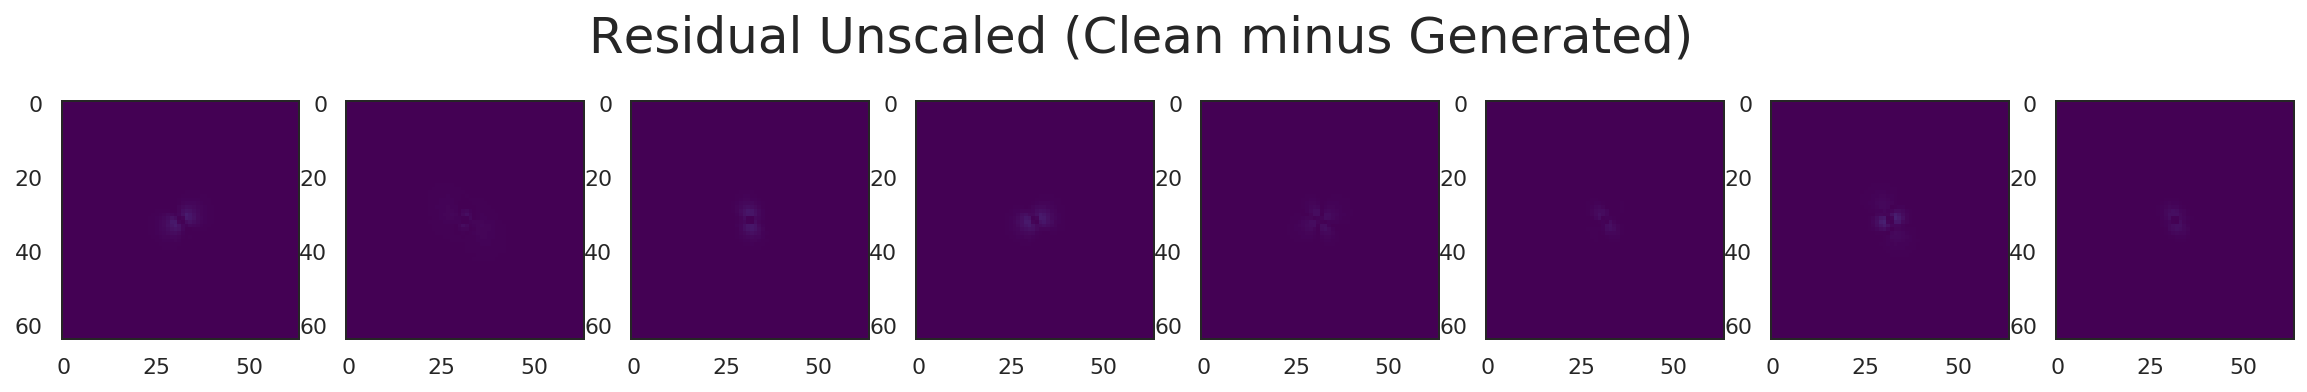

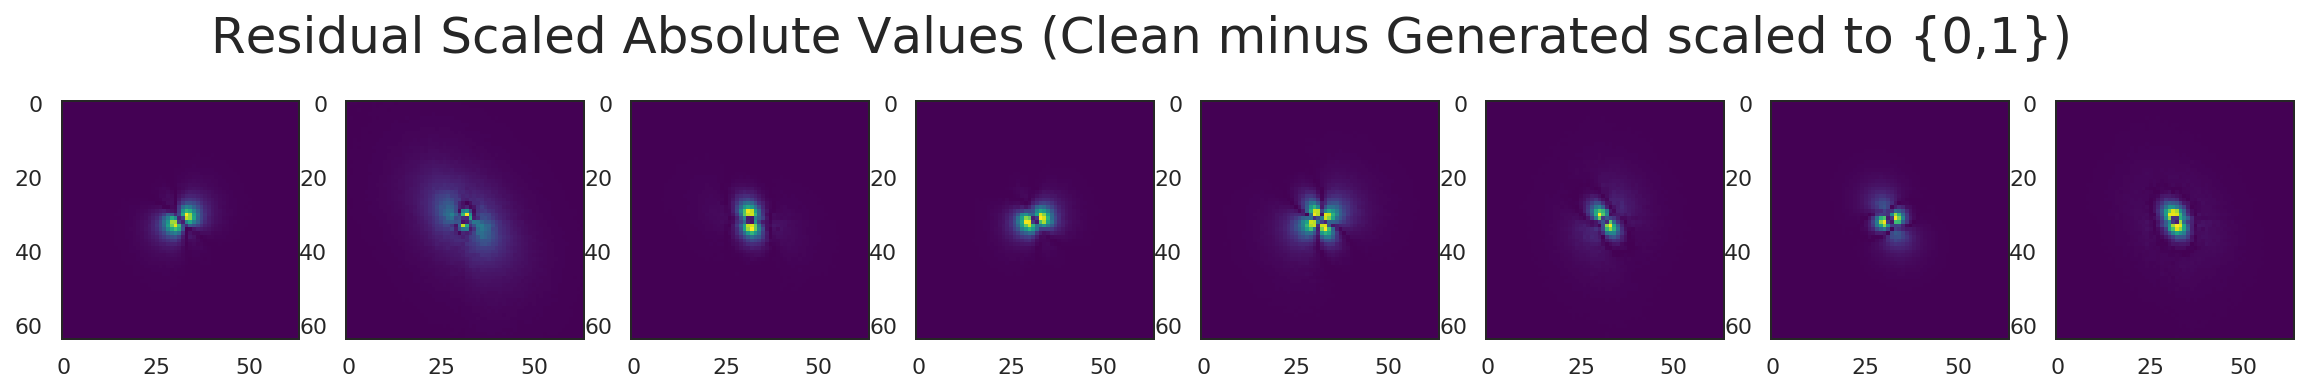

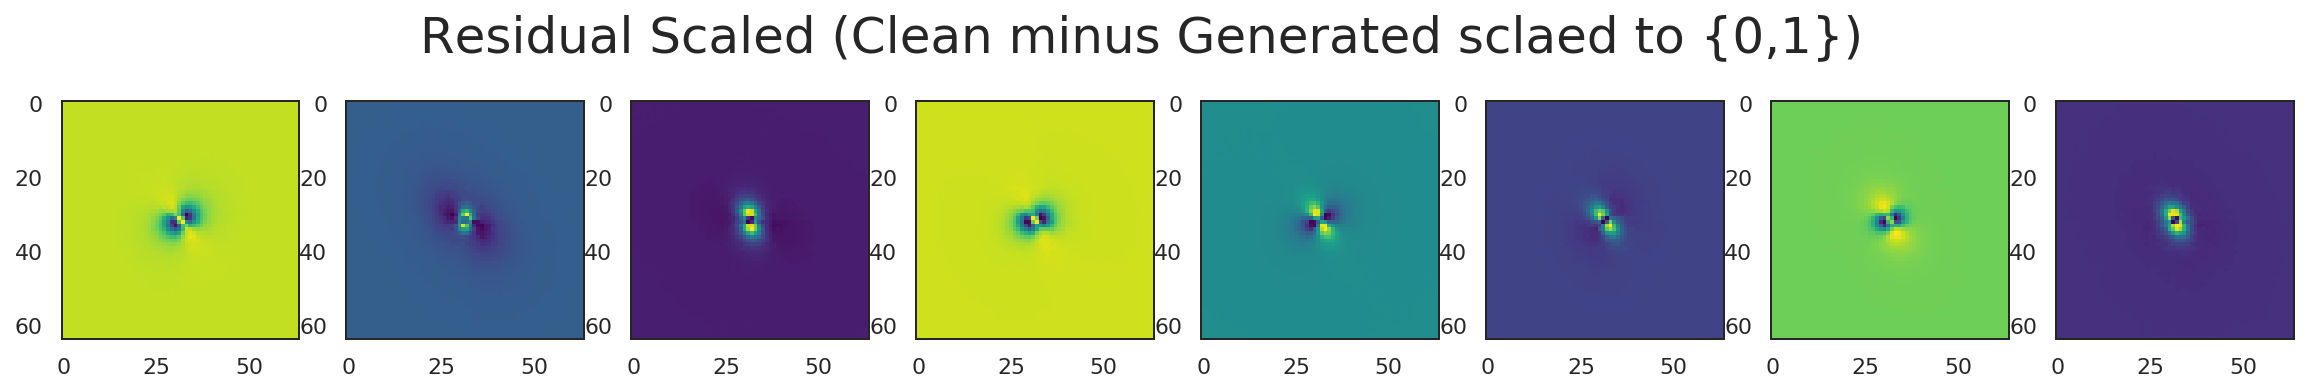

In [52]:
generate_images(CAE, test_ds)

<div class='gc'> <b> Variance Analysis for Label </b> </div>

In [53]:
pred = variance_analysis(CAE, test_ds, scaler2, label_test, test=True)

Bias          RMSE
Flux           9099.623047  14321.435547
Sersic Index      0.877976      1.206301
Sersic Radius     0.030189      0.067183
g1               -0.006398      0.091098
g2               -0.055258      0.111463

## <div class="theme"> End of Part 4 </div> 

## <div class="theme"> Part 5 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Test Dataset:  SNR = 60


| \# Samples | Avg. SNR | Flux [$10^5$] | Sersic index | Sersic radius | g1     | g2   | PSF  | Noise | Link                                                |
| ---------- | -------- | ------------- | ------------ | ------------- | ------ | ---- | ---- | ----- | --------------------------------------------------- |
| 10,000     | 59.90    | 1.0           | 3.0          | 0.3           | -0.069 | 0.15 | 0.5  | 200   | https://s3.amazonaws.com/measure.galaxies/snr60.npz |

### <div class='exercise'> <b> Step 1: Load the Testing dataset with average SNR of 30 </b> </div>

In [54]:
# Read the data set
(image_test,
 image_nonoise_test,
 label_test,
 psf_test,
 snr_test,
 sigma_test,
 psf_img_test,
 stats_test,
 mean_test) = load_data(set=5, test=True)


Available variables:
    img
    img_nonoise
    label
    psf_r
    psf_img
    snr
    sigma
    psf_image

Image Shape            = (10000, 64, 64)
No-noise Image Shape   = (10000, 64, 64)
Label Shape            = (10000, 5)
SNR Shape              = (10000,)
Sigma Shape            = (10000,)
PSF-R Shape            = (10000,)
Pixel Std-dev Shape    = (10000,)
Pixel Mean Shape       = (10000,)
PSF Image Shape        = (1, 64, 64)


### <div class='exercise'> <b> Step 2: Normalize the data </b> </div>

In [55]:
# Normalize the labels
label_test = norm_label(label_test, scaler=scaler1)

# Normalize the Images
image_nonoise_test = norm_image(image_nonoise_test, test=True)

### <div class='exercise'> <b> Step 3: Create Data Pipeline </b> </div>

<div class='gc'> <b> Create Dataset </b> </div>

In [56]:
# Create Tensorflow Dataset
testing = create_dataset(test=True)

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [57]:
test_ds = testing.map(
    pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### <div class='exercise'> <b> Step 4: Load Conditional Auto-encoder trained with variable Noise and fixed PSF </b> </div>

In [58]:
CAE.load_weights(paths[0])

### <div class='exercise'> <b> Step 5: Performance Analysis </b> </div>

<div class='gc'> <b> Generating reconstructed images for visual inspection </b> </div>

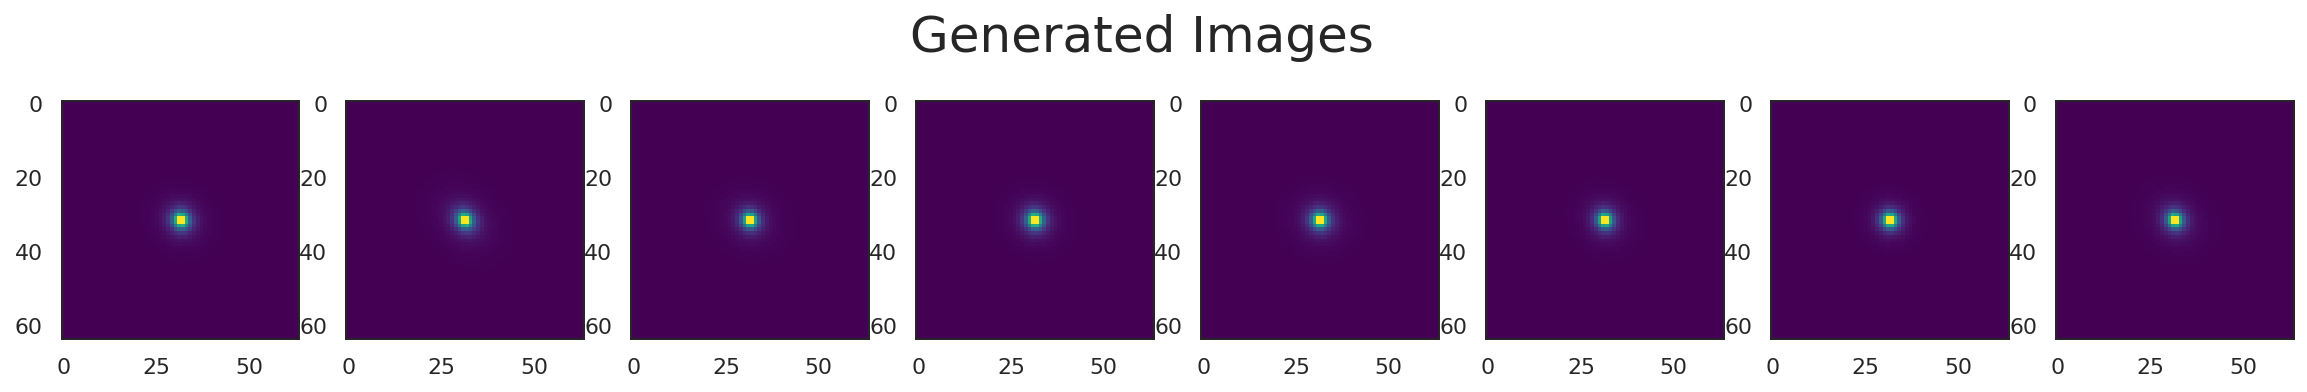

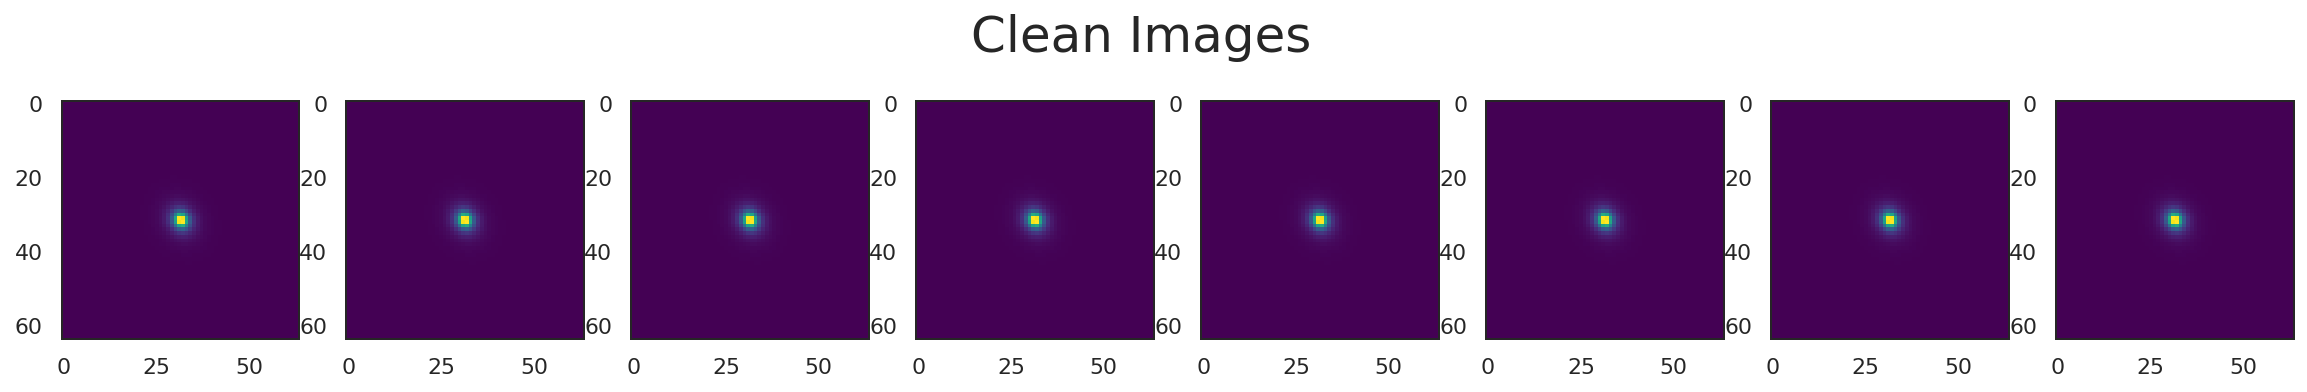

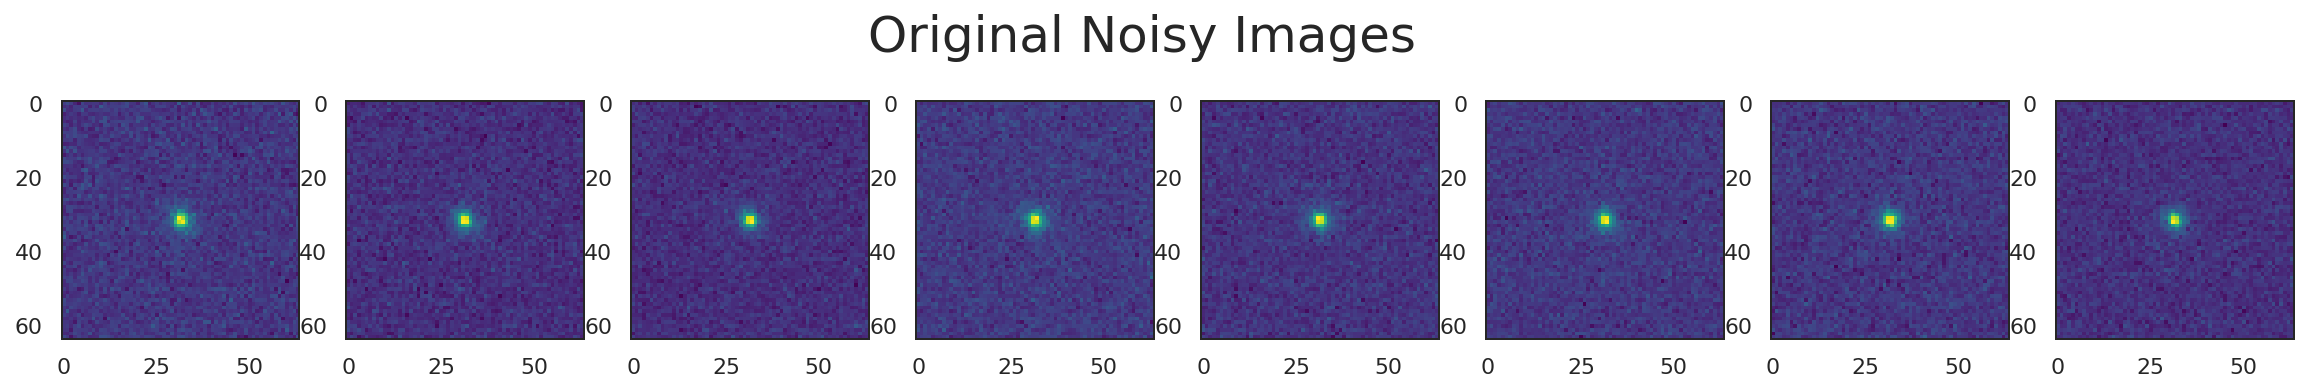

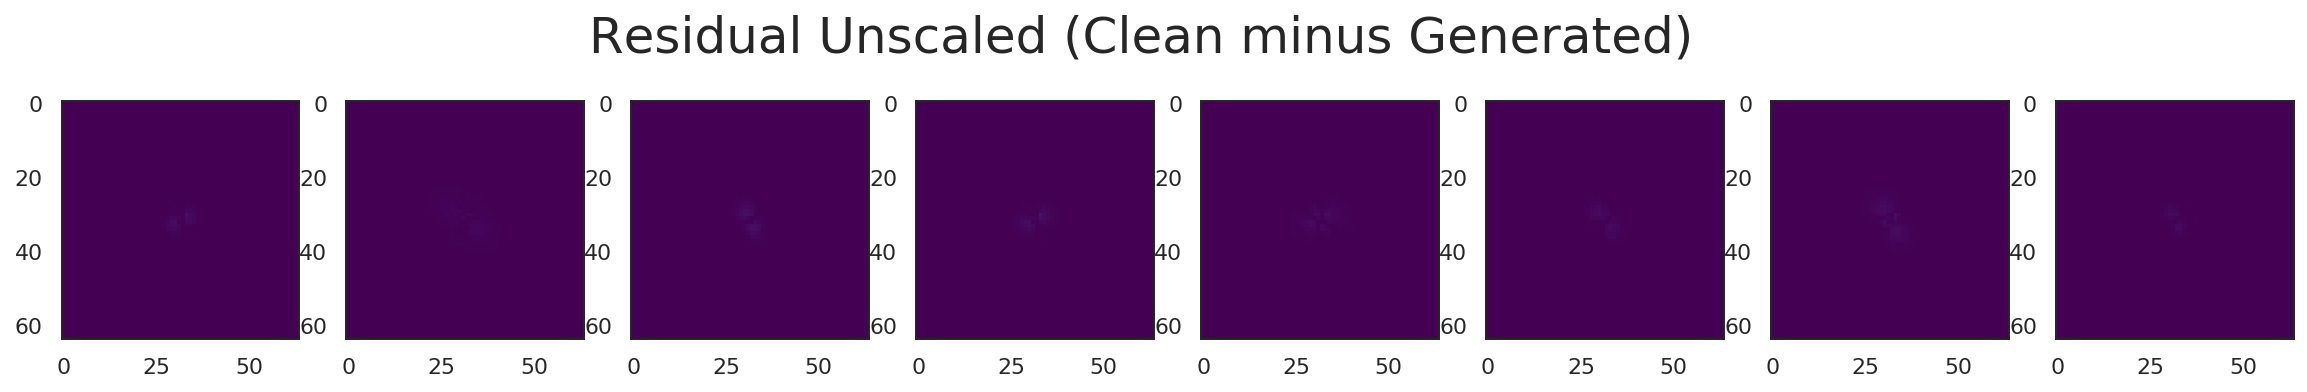

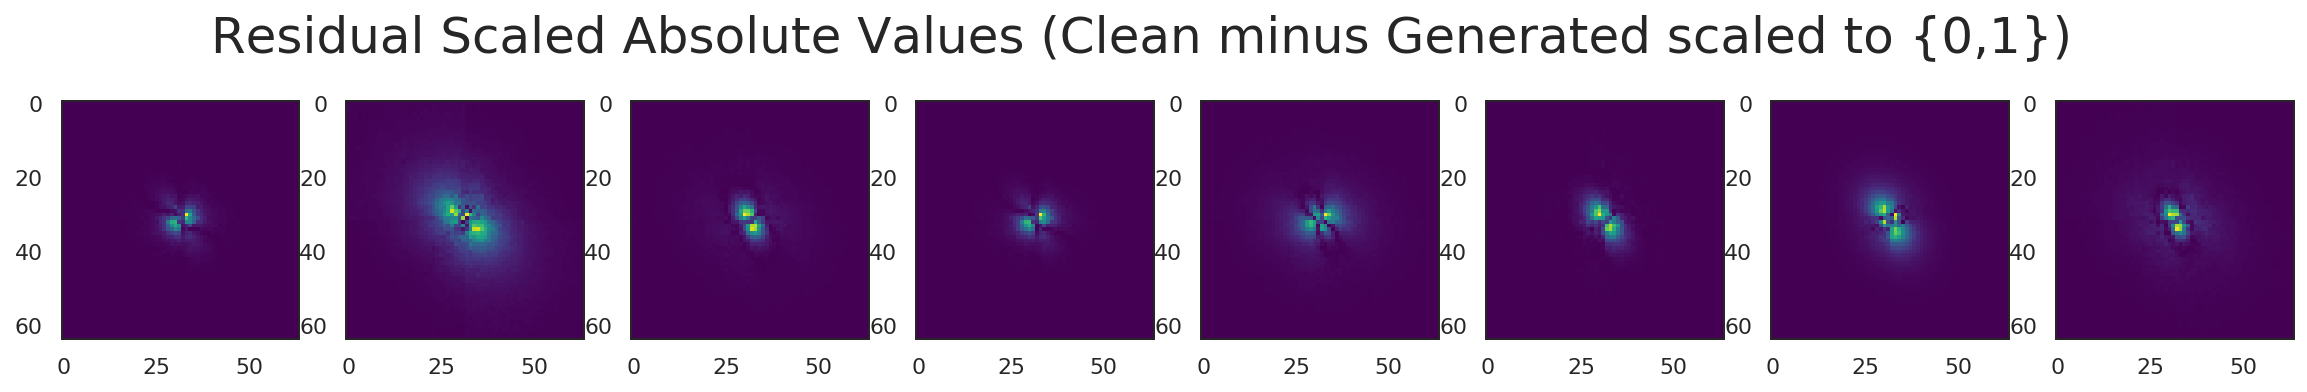

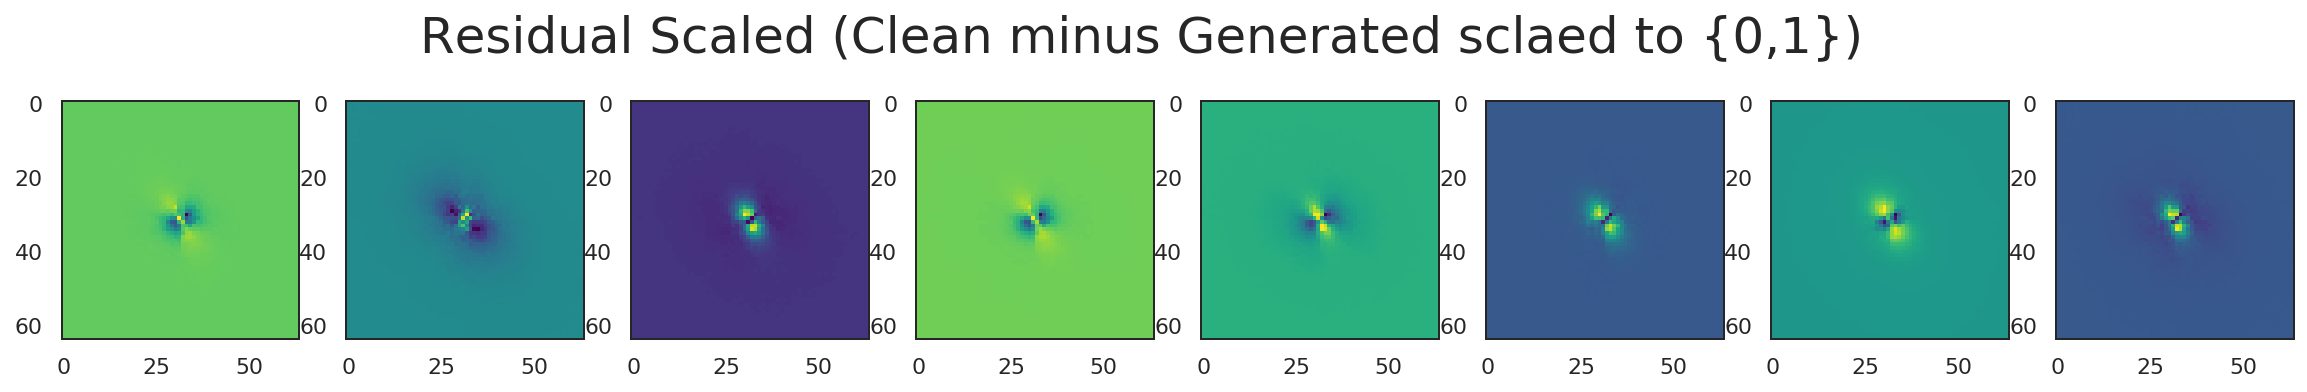

In [59]:
generate_images(CAE, test_ds)

<div class='gc'> <b> Variance Analysis for Label </b> </div>

In [60]:
pred = variance_analysis(CAE, test_ds, scaler1, label_test, test=True)

Bias         RMSE
Flux           7228.982422  9368.518555
Sersic Index      0.987976     1.206848
Sersic Radius     0.021609     0.047626
g1                0.008570     0.055755
g2               -0.009277     0.066274

## <div class="theme"> End of Part 5 </div> 

## <div class="theme"> Summary </div> 

<div style="border: 3px solid #800080; padding: 10px"> 
    
### ***Shape and Brightness of a Galaxy***


# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">  End Of Project
